# **Introduction**

In this tutorial, we demonstrate how to use DiffusionOT to train on the EMT dataset and perform downstream analyses such as Stochastic Trajectory Analysis (STA), inferring underlying Gene Regulatory Networks (GRNs), identifying critical genes, and conducting gene perturbation analysis.

## Load data and initiate model

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
import joblib
sys.path.append('C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\')
from utility import *
args = create_args()

random.seed(args.seed)
torch.manual_seed(args.seed)
device = torch.device('cpu')
# load dataset 
data = np.load(args.input_dir+'/EMT.npz', allow_pickle=True)
latent_ae_scaled = data['pca_scaled']
time_label = data['time_label'].astype(str)
type_label = data['type_label']
time_all = ['1','2','3','4']
data_train = []
data_type = []
for k in range(len(time_all)):
    indices = [i for i, l in enumerate(time_label) if l == time_all[k]]
    samples = latent_ae_scaled[indices,]
    cell_type = type_label[indices,]
    samples = torch.from_numpy(samples).type(torch.float32).to(device)
    data_train.append(samples)
    data_type.append(cell_type)
    
integral_time = args.timepoints
time_pts = range(len(data_train))
leave_1_out = []
train_time = [x for i,x in enumerate(time_pts) if i!=leave_1_out]

# model
func = RUOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation,d=args.d).to(device)
func.apply(initialize_weights)

# configure training options
options = {}
options.update({'method': 'Dopri5'})
options.update({'h': None})
options.update({'rtol': 1e-3})
options.update({'atol': 1e-5})
options.update({'print_neval': False})
options.update({'neval_max': 1000000})
options.update({'safety': None})
optimizer = optim.Adam(func.parameters(), lr=args.lr, weight_decay=0.01)
lr_adjust = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[
                                            args.niters-400, args.niters-200], gamma=0.5, last_epoch=-1)
mse = nn.MSELoss()
LOSS = []
L2_1 = []
L2_2 = []
L2_3 = []
L2_4 = []
Trans = []
Sigma = []

Name of the data set. Options: EMT; Mouse; Zebrafish; Spatial; MISA (default: MISA):  EMT
Time points of data (default: 0,1,2,6):  0,0.2,0.6,1.0
Number of training iterations (default: 5000):  2000
Learning rate (default: 3e-3):  
Number of sampling points per epoch (default: 100):  500
Dimension of the hidden layer (default: 16):  
Number of hidden layers (default: 4):  
Activation function (default: Tanh):  
GPU device index (default: 0):  
Input Files Directory (default: Input/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Input
Output Files Directory (default: Output/):  C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output
Random seed (default: 1):  
Diffusion coefficient (default: 0.001):  


## Pretrain the score

In [2]:
# fix func.hyper_net1，hyper_net2
fixed_layers = [func.hyper_net1, func.hyper_net2]
func.d.requires_grad = False#True
for layer in fixed_layers:
    for param in layer.parameters():
        param.requires_grad = False
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)

sigma_now = 1
loss_score_all=[]
for itr in range(1, 200 + 1):#args.niters
    optimizer.zero_grad()     
    loss_score= pre_train_score(mse,func,args,data_train,train_time,integral_time,sigma_now,device,itr)
    loss_score.backward()
    optimizer.step()
    print('Pre_train_score_Iter: {}, loss: {:.4f}'.format(itr, loss_score.item()))
    loss_score_all.append(loss_score.item())
            
##save pre_train result        
ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_score.pth'.format(args.dataset))
torch.save({'func_state_dict': func.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, ckpt_path)
print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))    

Pre_train_score_Iter: 1, loss: 0.2696
Pre_train_score_Iter: 2, loss: 0.0508
Pre_train_score_Iter: 3, loss: -0.1392
Pre_train_score_Iter: 4, loss: -0.3034
Pre_train_score_Iter: 5, loss: -0.4664
Pre_train_score_Iter: 6, loss: -0.5834
Pre_train_score_Iter: 7, loss: -0.7064
Pre_train_score_Iter: 8, loss: -0.8257
Pre_train_score_Iter: 9, loss: -0.9410
Pre_train_score_Iter: 10, loss: -0.9753
Pre_train_score_Iter: 11, loss: -1.1138
Pre_train_score_Iter: 12, loss: -1.1512
Pre_train_score_Iter: 13, loss: -1.1819
Pre_train_score_Iter: 14, loss: -1.3084
Pre_train_score_Iter: 15, loss: -1.2652
Pre_train_score_Iter: 16, loss: -1.3092
Pre_train_score_Iter: 17, loss: -1.2915
Pre_train_score_Iter: 18, loss: -1.3762
Pre_train_score_Iter: 19, loss: -1.4226
Pre_train_score_Iter: 20, loss: -1.3367
Pre_train_score_Iter: 21, loss: -1.4386
Pre_train_score_Iter: 22, loss: -1.4657
Pre_train_score_Iter: 23, loss: -1.3392
Pre_train_score_Iter: 24, loss: -1.4540
Pre_train_score_Iter: 25, loss: -1.3650
Pre_train_s

## Pretrain the velocity and growth

In [3]:
fixed_layers = [func.hyper_net3]
train_layers = [func.hyper_net1, func.hyper_net2]
func.d.requires_grad = False#True
for layer in fixed_layers:
    for param in layer.parameters():
        param.requires_grad = False
for layer in train_layers:
    for param in layer.parameters():
        param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)#args.lr
sigma_now = 1
l=1
for itr in range(1,  100+ 1):#args.niters
    optimizer.zero_grad()
    loss, sigma_now, L2_value3,L2_value4= pre_train_model(mse,func,args,data_train,train_time,integral_time,sigma_now,options,device,itr)
    loss.backward()
    optimizer.step()
    lr_adjust.step()
    l=loss.item()
    LOSS.append(loss.item())
    Sigma.append(sigma_now)
    L2_3.append(L2_value3.tolist())     
    print('Iter: {}, loss: {:.4f}'.format(itr, loss.item()))
        
ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_pre.pth'.format(args.dataset,itr))
torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))

Iter: 1, loss: 7.1976
Iter: 2, loss: 7.0329
Iter: 3, loss: 6.8153
Iter: 4, loss: 6.6918
Iter: 5, loss: 6.6636
Iter: 6, loss: 6.4890
Iter: 7, loss: 6.4399
Iter: 8, loss: 6.3512
Iter: 9, loss: 6.2807
Iter: 10, loss: 6.2308
Iter: 11, loss: 6.1645
Iter: 12, loss: 6.1194
Iter: 13, loss: 6.0395
Iter: 14, loss: 6.0714
Iter: 15, loss: 5.9882
Iter: 16, loss: 5.9349
Iter: 17, loss: 5.9544
Iter: 18, loss: 5.9681
Iter: 19, loss: 5.8928
Iter: 20, loss: 5.7944
Iter: 21, loss: 5.8236
Iter: 22, loss: 5.7325
Iter: 23, loss: 5.7647
Iter: 24, loss: 5.7247
Iter: 25, loss: 5.7360
Iter: 26, loss: 5.6885
Iter: 27, loss: 5.7264
Iter: 28, loss: 5.6311
Iter: 29, loss: 5.6976
Iter: 30, loss: 5.6935
Iter: 31, loss: 5.6302
Iter: 32, loss: 5.5922
Iter: 33, loss: 5.5705
Iter: 34, loss: 5.5493
Iter: 35, loss: 5.6287
Iter: 36, loss: 5.5182
Iter: 37, loss: 5.5187
Iter: 38, loss: 5.4970
Iter: 39, loss: 5.5035
Iter: 40, loss: 5.4588
Iter: 41, loss: 5.5363
Iter: 42, loss: 5.4794
Iter: 43, loss: 5.4634
Iter: 44, loss: 5.51

## Training the total loss

In [4]:
train_layers = [func.hyper_net1, func.hyper_net2,func.hyper_net3]
func.d.requires_grad = False#True
for layer in train_layers:
    for param in layer.parameters():
        param.requires_grad = True
optimizer = optim.Adam(filter(lambda p: p.requires_grad, func.parameters()), lr=args.lr, weight_decay=0.01)#args.lr

sigma_now = 0.5
D_all=[]
for itr in range(1, args.niters + 1):#args.niters
    optimizer.zero_grad()
    loss, loss1, sigma_now, L2_value1, L2_value2, L2_value3, L2_value4= train_model(mse,func,args,data_train,train_time,integral_time,sigma_now,options,device,itr)
    loss.backward()
    optimizer.step()
    lr_adjust.step()      
    LOSS.append(loss.item())
    Trans.append(loss1[-1].mean(0).item())
    Sigma.append(sigma_now)
    L2_1.append(L2_value1.tolist())
    L2_2.append(L2_value2.tolist())
    L2_3.append(L2_value3.tolist())
    L2_4.append(L2_value4.tolist())
    print('Iter: {}, loss: {:.4f}'.format(itr, loss.item()))
    if itr % 500 == 0:
        D_t=diffusion_fit(func,args,data_train,train_time,integral_time,device,time_tt=0.01)
        D=torch.mean(D_t)
        D_all.append(D.detach().cpu().numpy())
        ckpt_path = os.path.join(args.save_dir, 'ckpt_{}_itr{}.pth'.format(args.dataset,itr))
        torch.save({'func_state_dict': func.state_dict()}, ckpt_path)
        print('Iter {}, Stored ckpt at {}'.format(itr, ckpt_path))
            
    if (itr%100 == 0) and (itr<500):
        D_t=diffusion_fit(func,args,data_train,train_time,integral_time,device,time_tt=0.01)
        D=torch.mean(D_t)
        D_all.append(D.detach().cpu().numpy())
        func.d=torch.nn.Parameter(D)

ckpt_path = os.path.join(args.save_dir, 'ckpt_{}.pth'.format(args.dataset))
torch.save({
    'func_state_dict': func.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'LOSS':LOSS,
    'TRANS':Trans,
    'L2_1': L2_1,
    'L2_2': L2_2,
    'L2_3': L2_3,
    'L2_4': L2_4,
    'Sigma': Sigma,
    'D':D_all,
    }, ckpt_path)
print('Stored ckpt at {}'.format(ckpt_path))

Iter: 1, loss: 671.3754
Iter: 2, loss: 157.8433
Iter: 3, loss: 87.0769
Iter: 4, loss: 153.7649
Iter: 5, loss: 205.2131
Iter: 6, loss: 243.3334
Iter: 7, loss: 243.0489
Iter: 8, loss: 232.3042
Iter: 9, loss: 209.2167
Iter: 10, loss: 215.6025
Iter: 11, loss: 150.4843
Iter: 12, loss: 105.5374
Iter: 13, loss: 79.1595
Iter: 14, loss: 70.7868
Iter: 15, loss: 59.8800
Iter: 16, loss: 65.8638
Iter: 17, loss: 79.2571
Iter: 18, loss: 99.7058
Iter: 19, loss: 100.1635
Iter: 20, loss: 91.1955
Iter: 21, loss: 68.0928
Iter: 22, loss: 56.6183
Iter: 23, loss: 58.2804
Iter: 24, loss: 45.6960
Iter: 25, loss: 45.3417
Iter: 26, loss: 52.3212
Iter: 27, loss: 53.2235
Iter: 28, loss: 66.1486
Iter: 29, loss: 62.0805
Iter: 30, loss: 52.8497
Iter: 31, loss: 59.7407
Iter: 32, loss: 45.6924
Iter: 33, loss: 41.7760
Iter: 34, loss: 49.2694
Iter: 35, loss: 45.9234
Iter: 36, loss: 55.2268
Iter: 37, loss: 56.9632
Iter: 38, loss: 52.2515
Iter: 39, loss: 44.8378
Iter: 40, loss: 44.5768
Iter: 41, loss: 36.4210
Iter: 42, los

## Visualization

In [2]:
func = RUOT(in_out_dim=data_train[0].shape[1], hidden_dim=args.hidden_dim,n_hiddens=args.n_hiddens,activation=args.activation,d =args.d).to(device)
# load trained networks
if args.save_dir is not None:
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)
    ckpt_path = os.path.join(args.save_dir, 'ckpt_EMT.pth')#'ckpt6_MISA3_D_{:.3f}.pth'.format(D0) 'ckpt6_MISA4.pth''ckpt_EMT.pth'ckpt_Simulation_itr2000_D_0.040
    if os.path.exists(ckpt_path):
        checkpoint = torch.load(ckpt_path,map_location=torch.device('cpu'))
        func.load_state_dict(checkpoint['func_state_dict'])
        print('Loaded ckpt from {}'.format(ckpt_path))

Loaded ckpt from C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\ckpt_EMT.pth


## Cell velocity

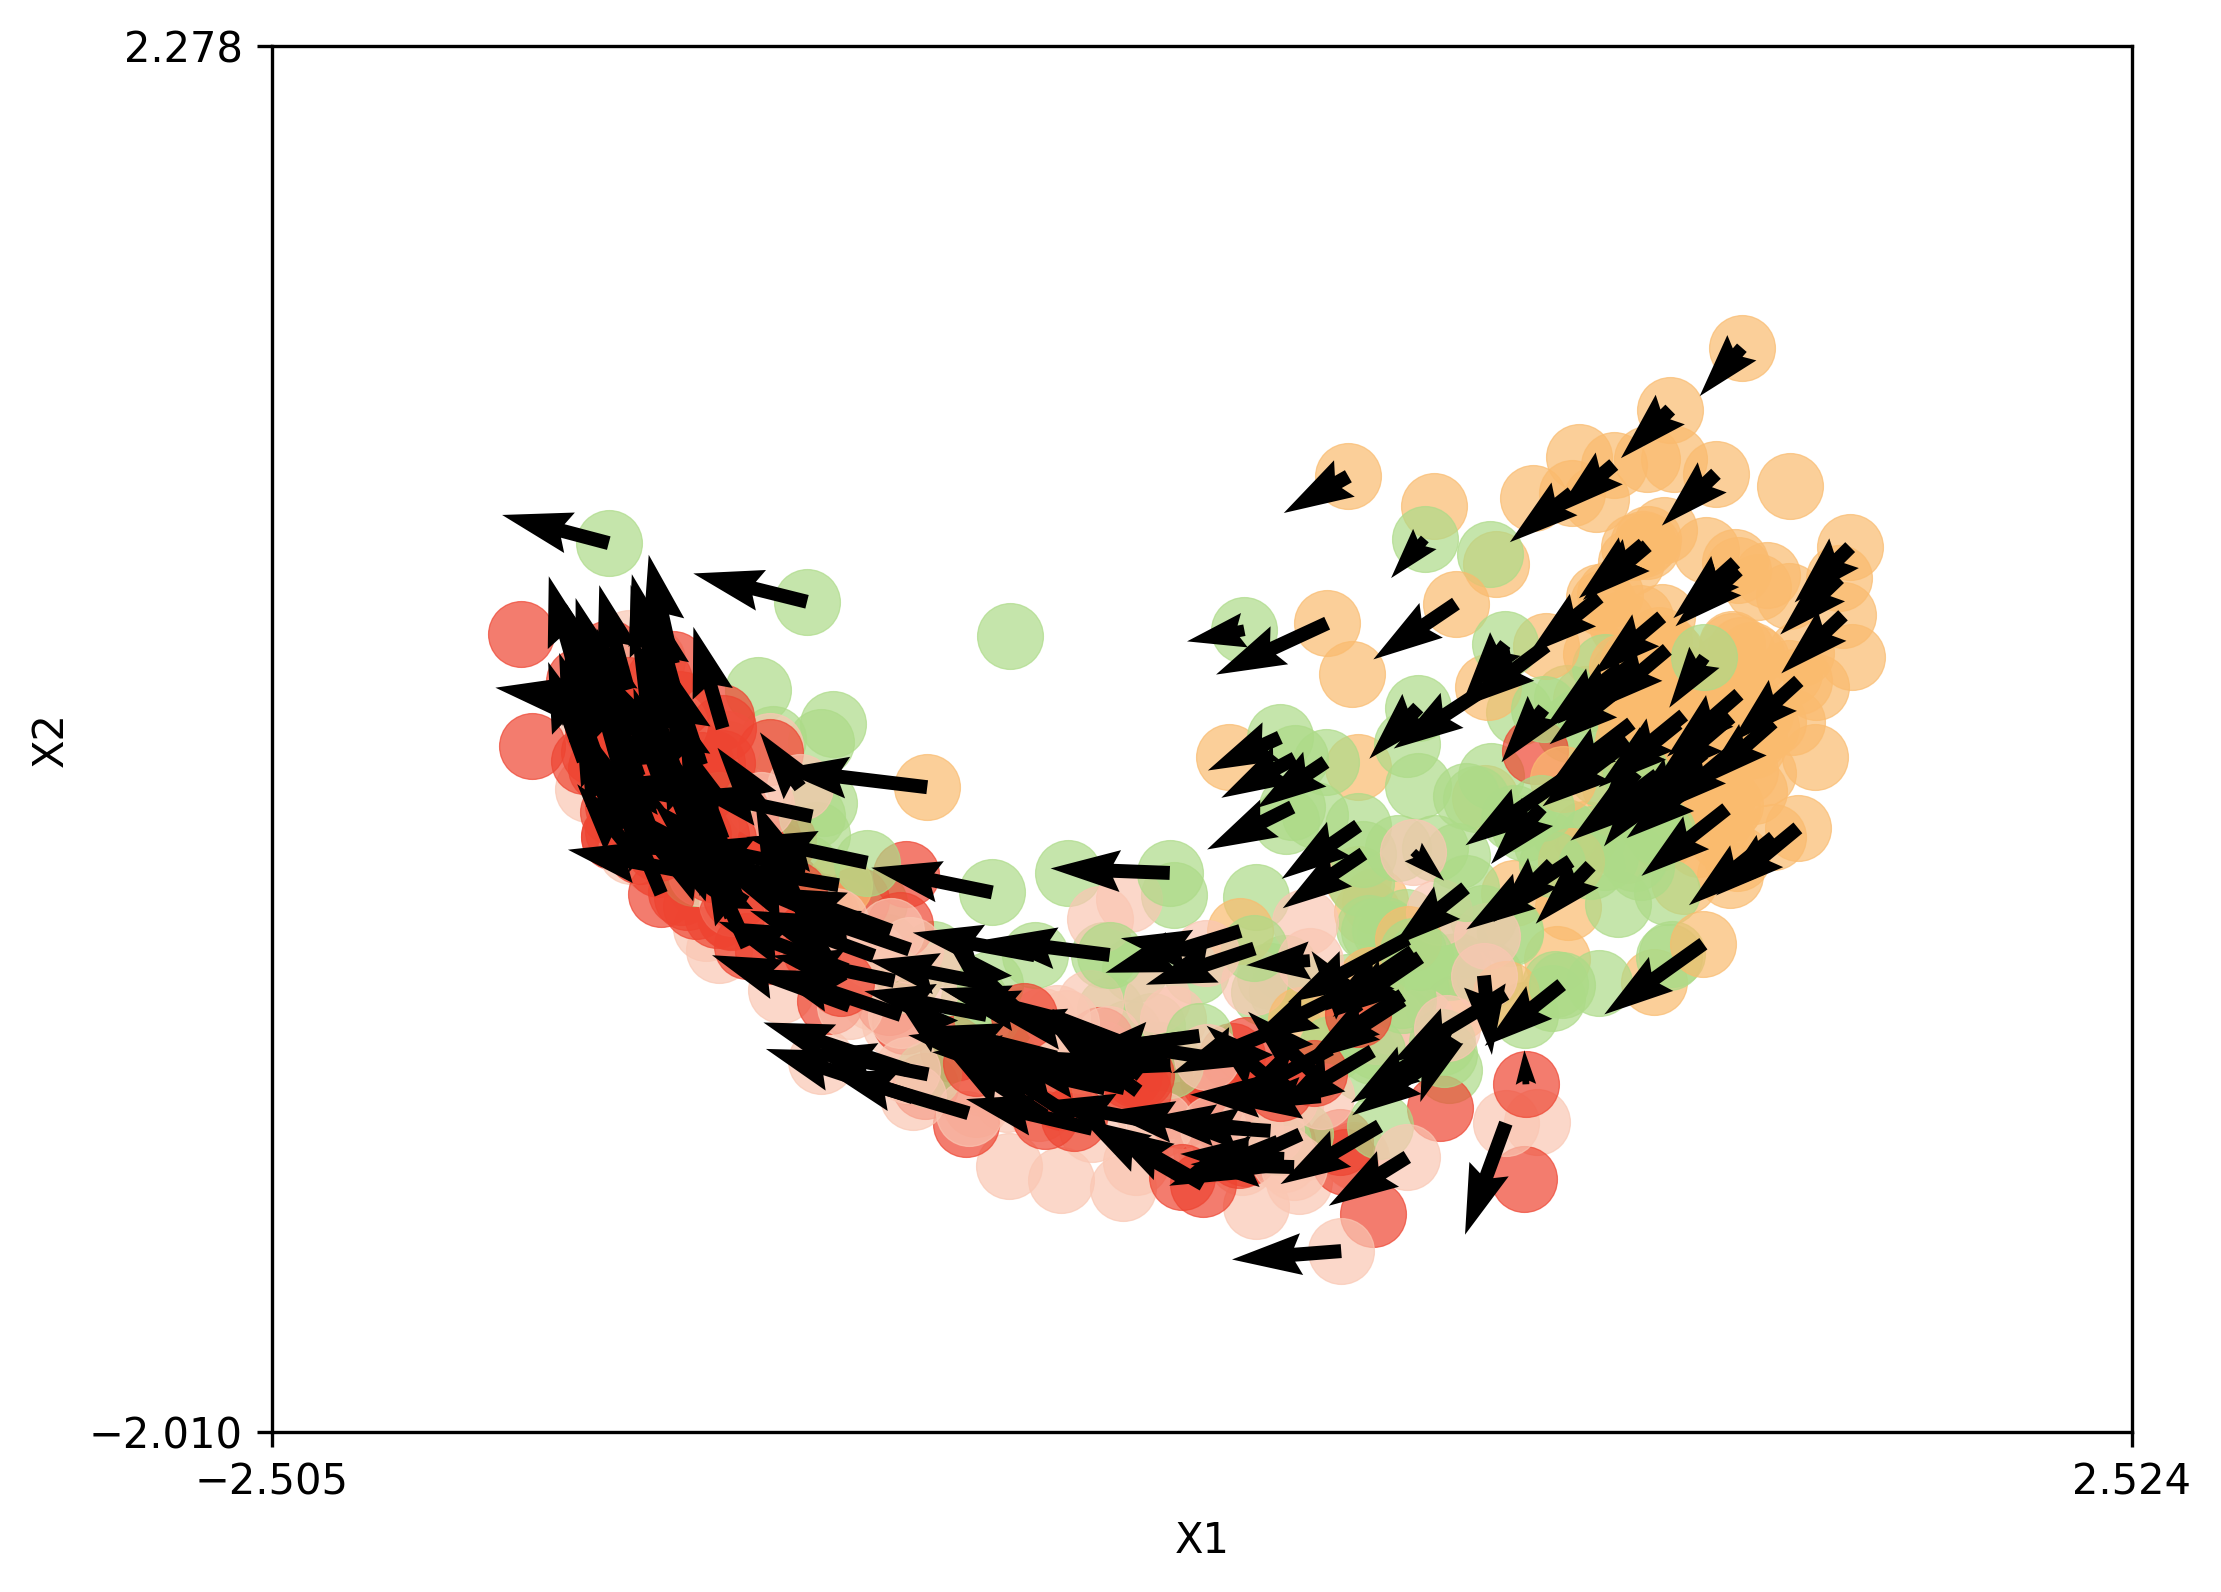

In [11]:
plot_2d_v(func,data_train,train_time,integral_time,args,device)  

## Plot trajectory and growth

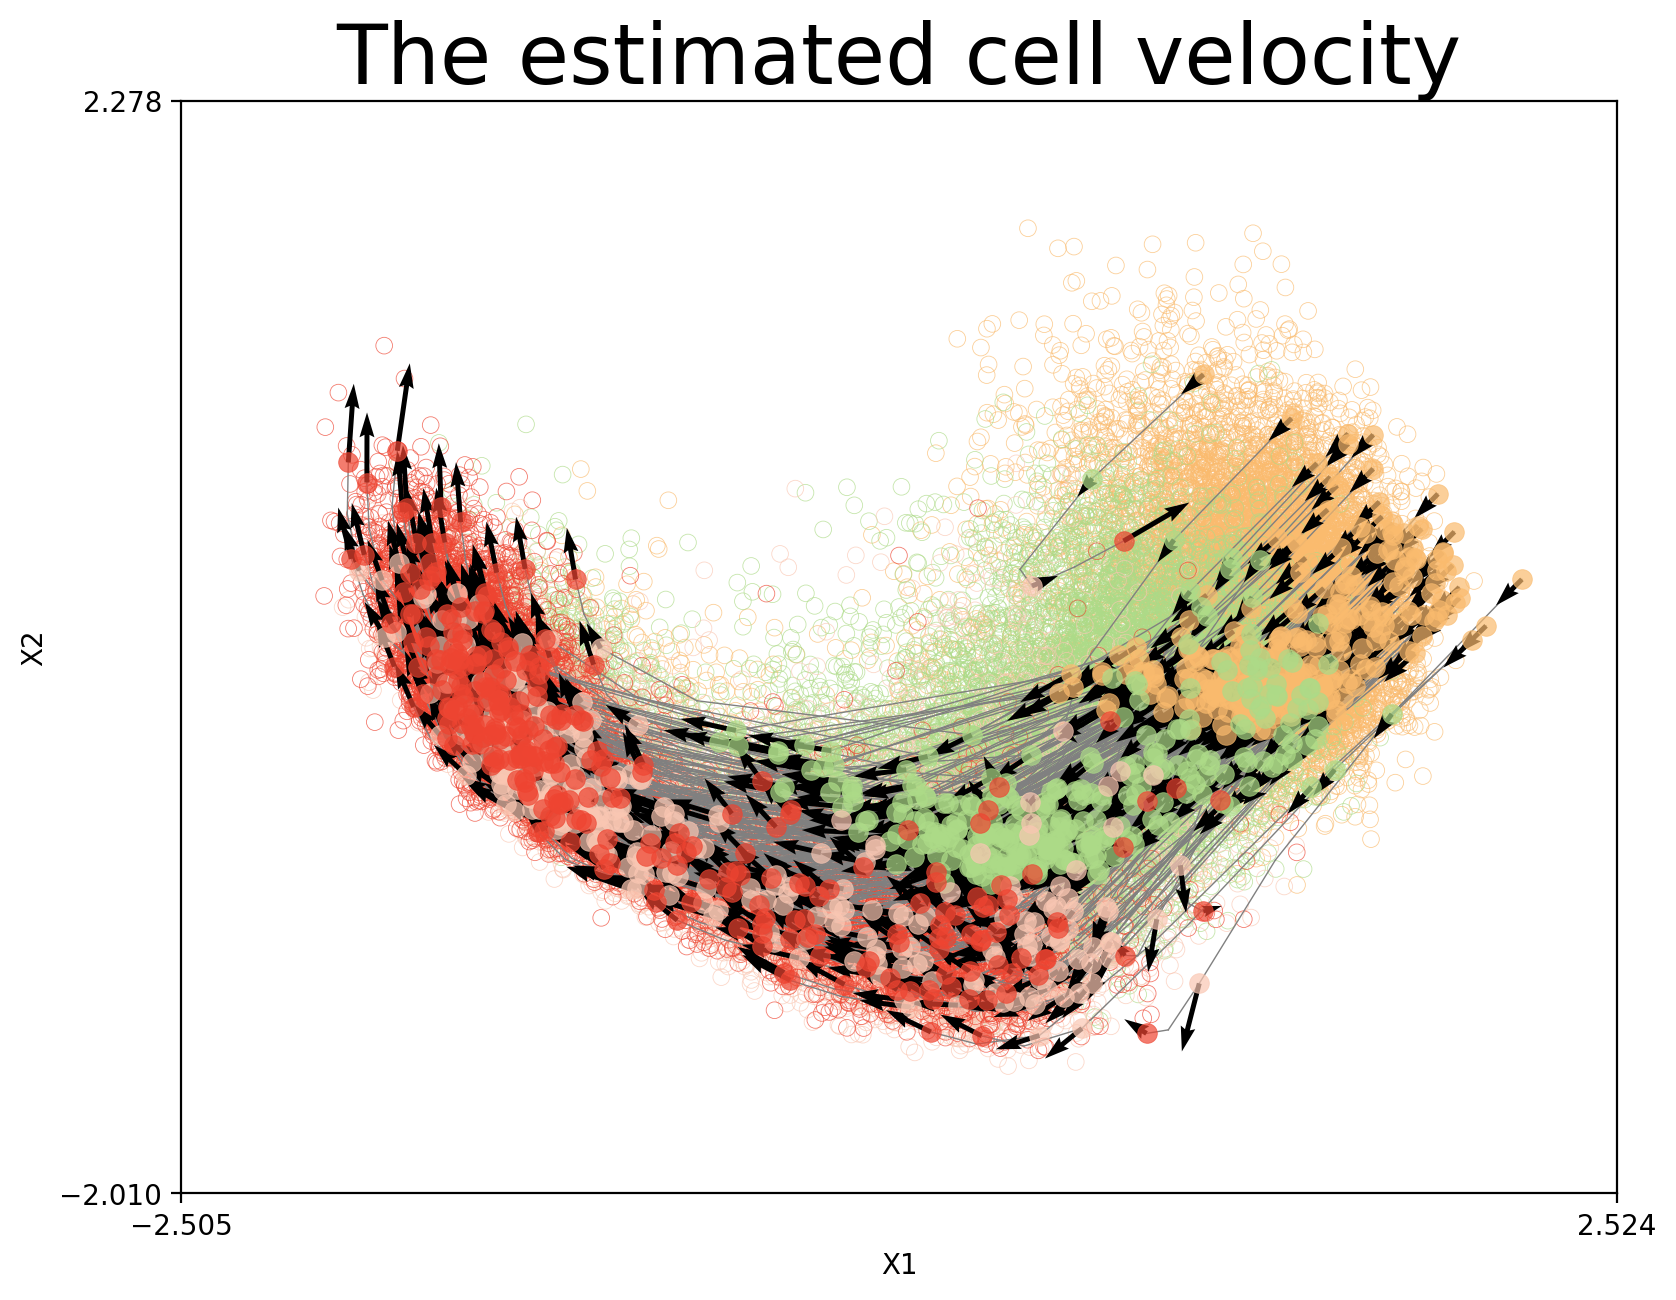

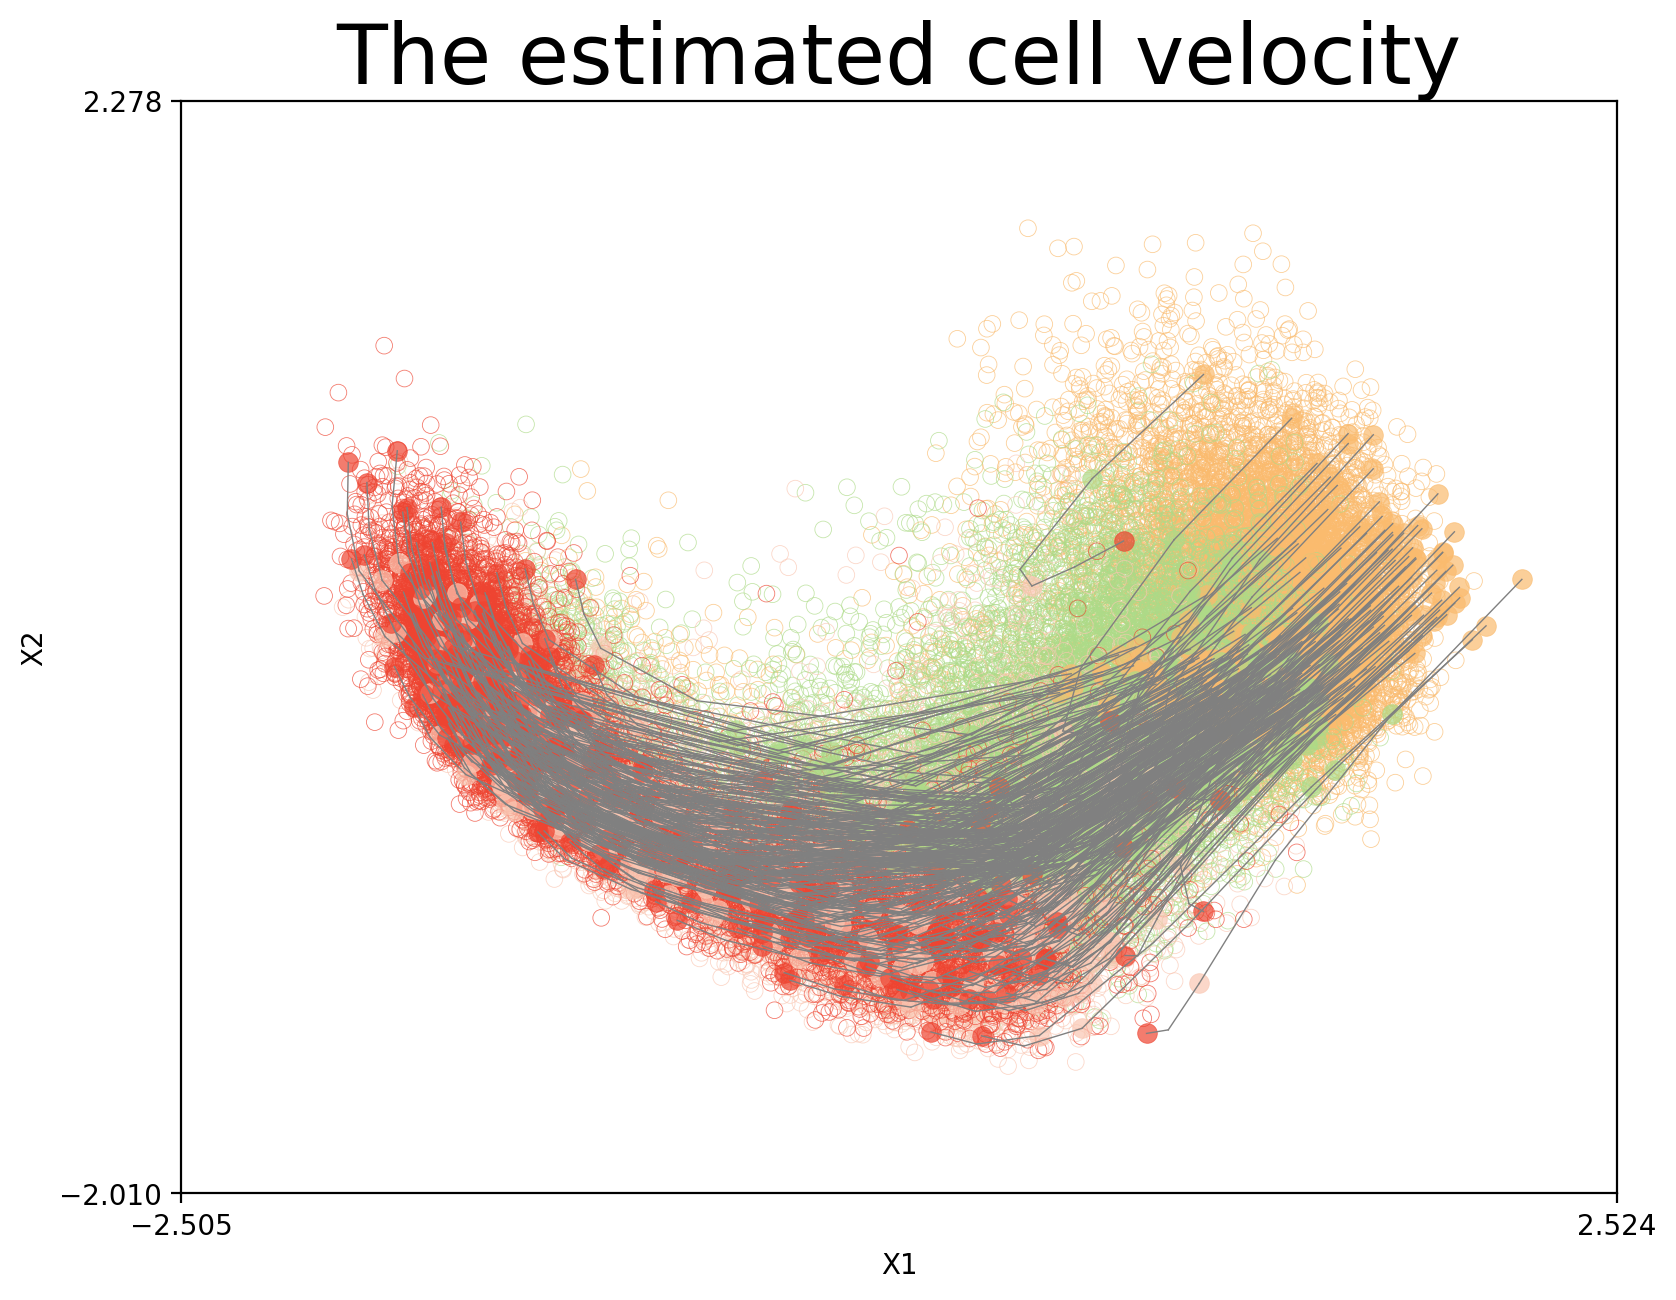

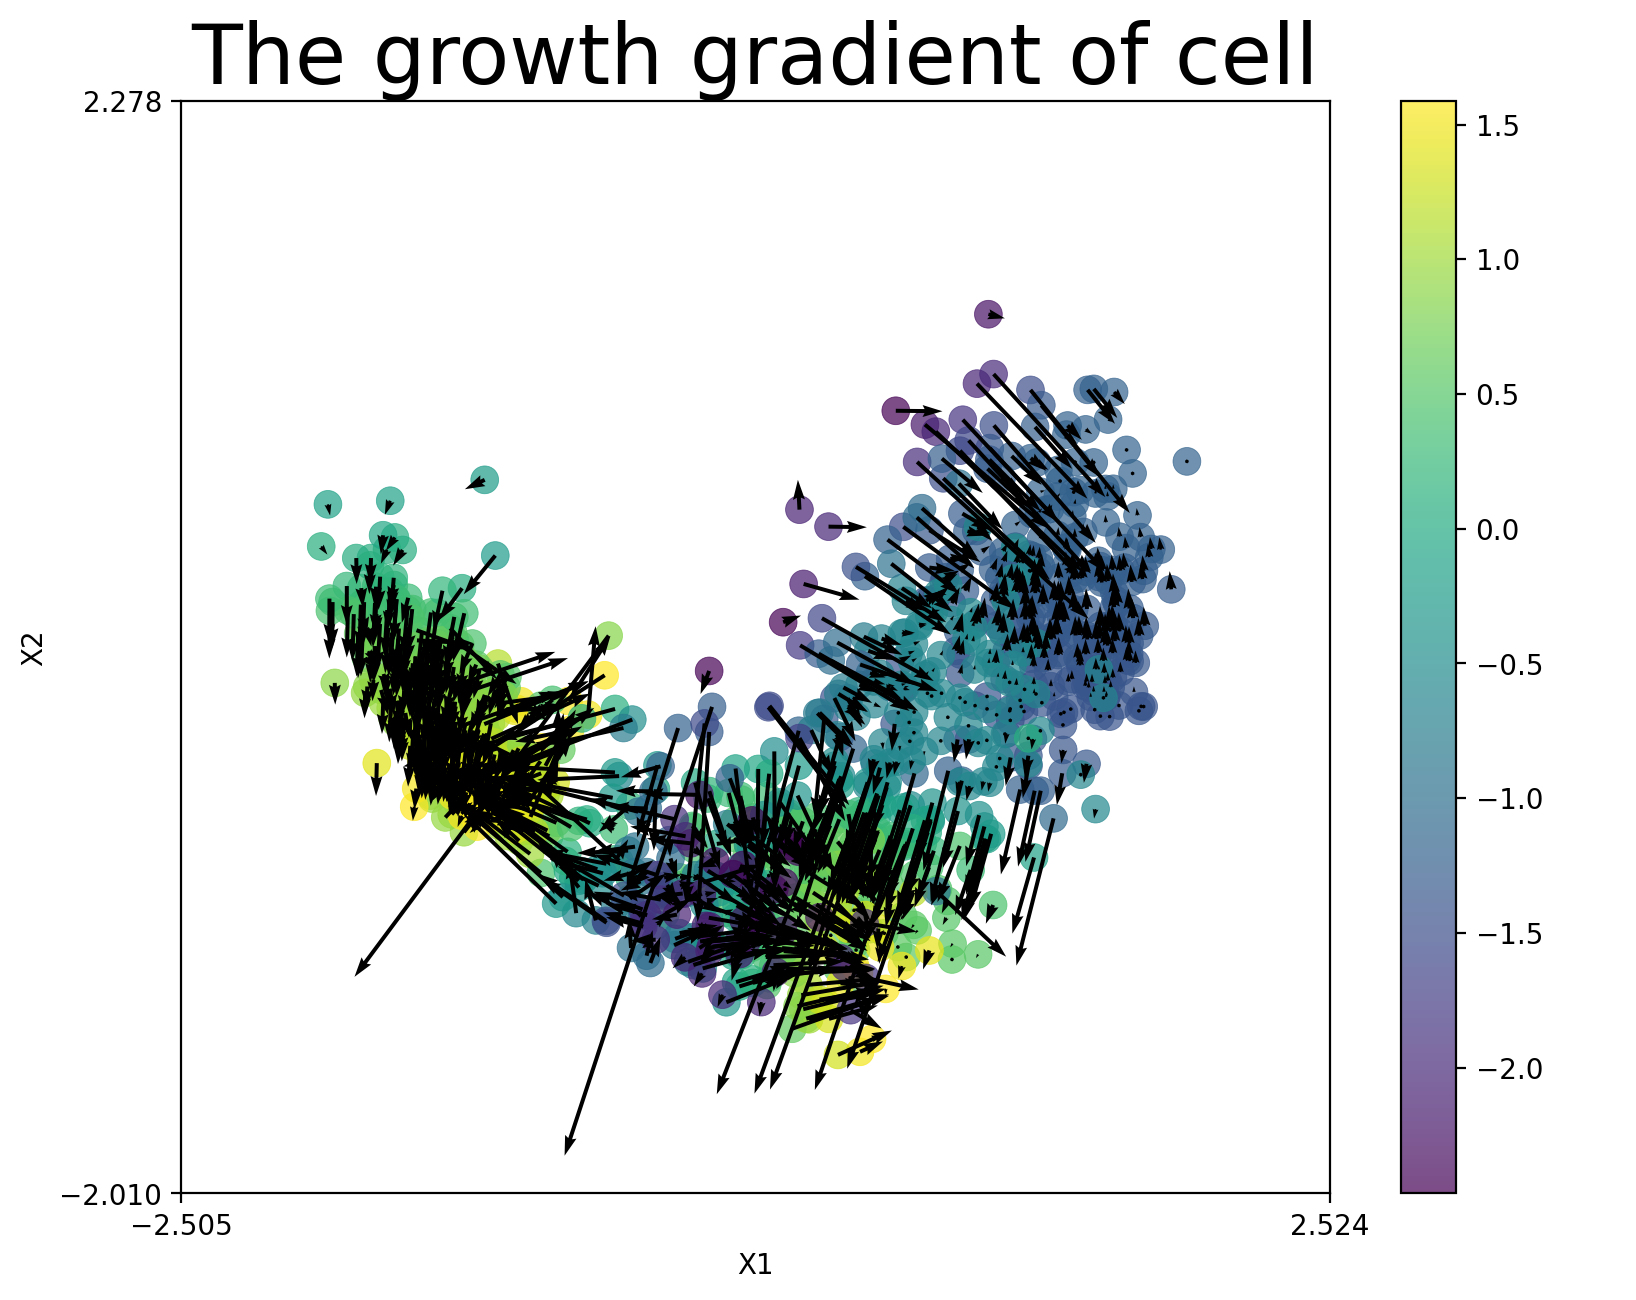

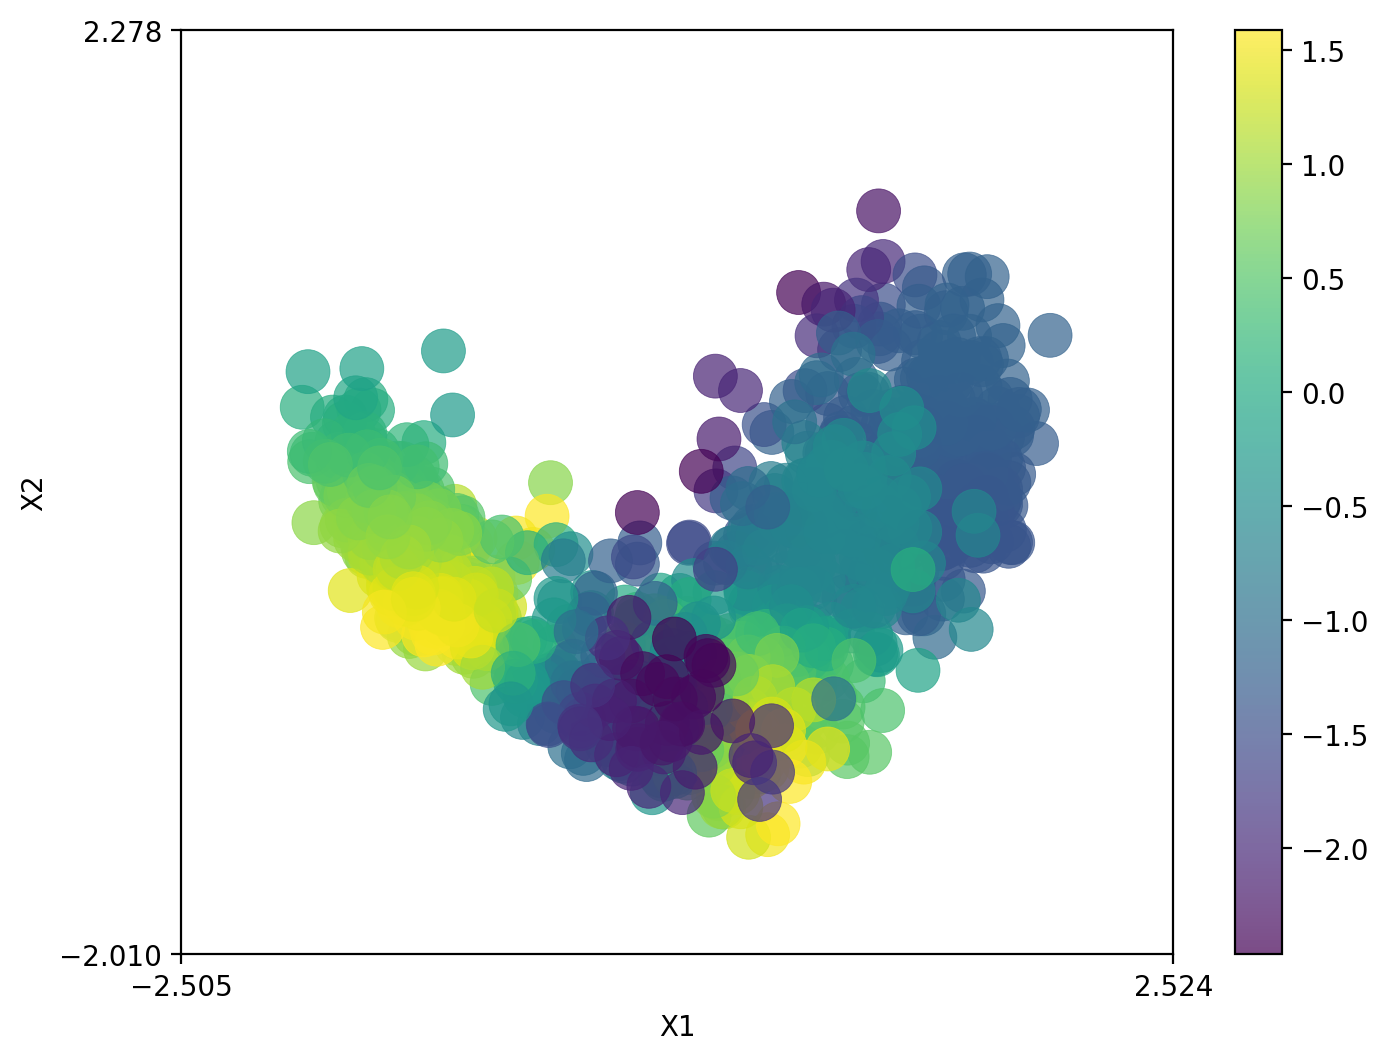

In [12]:
plot_2d(func,data_train,train_time,integral_time,args,device)  

## Identifying growth-related genes

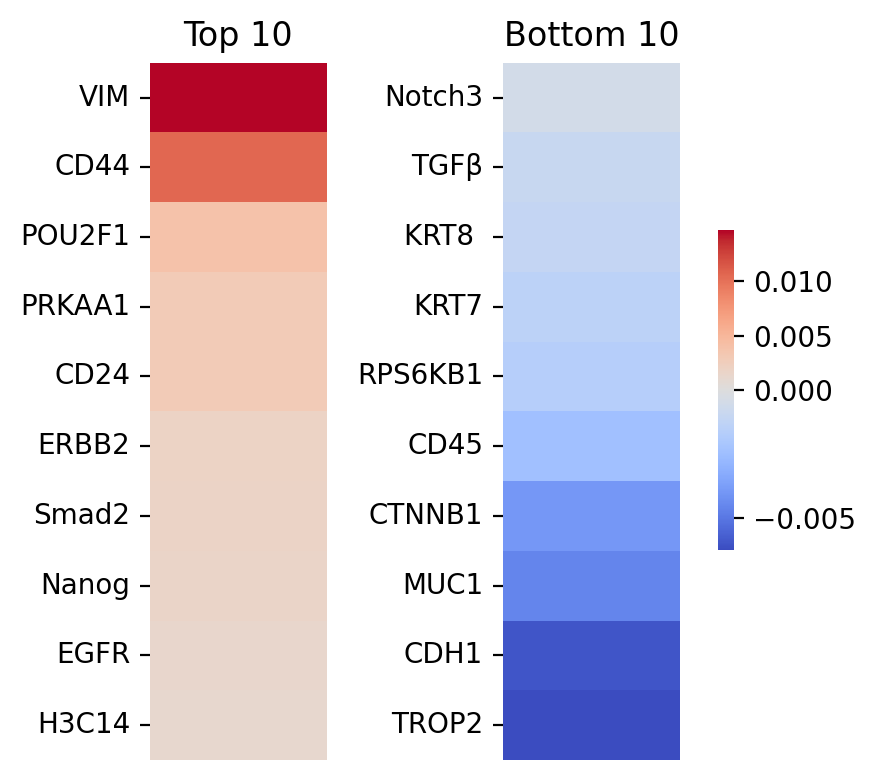

In [3]:
viz_samples = 50
max_use = 10
min_use = -8
mean_use = 0
filepath='C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\\'
title='EMT_growth_V6'
pca_model = joblib.load(filepath+'pca_model_2d_EMT.pkl')
gene_name = pd.read_csv('C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Rawdata\\gene_name_EMT.csv', header=0,index_col=0).values.tolist()
gene_name = [name[0] for name in gene_name] 
z_t0 =  Sampling(viz_samples, train_time, 0,data_train,0.001,device)#Importance
z_t0.requires_grad_()
Growth_ave_top(viz_samples,z_t0,integral_time[0],device,max_use,min_use,mean_use,gene_name,filepath,title,func,pca_model) 

## Inferring the underlying GRN

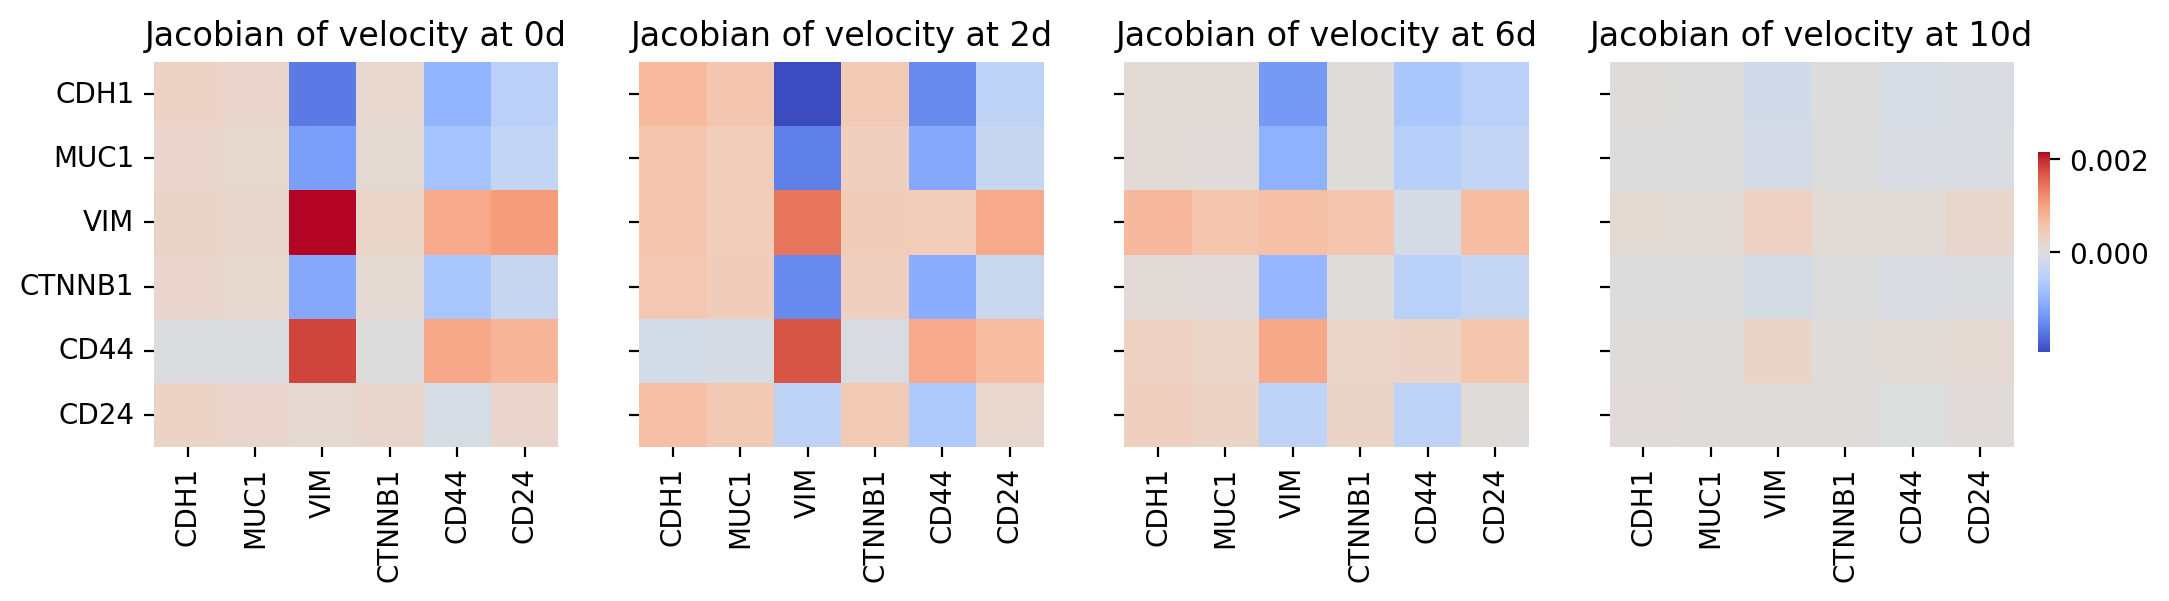

In [4]:
sigma_a=0.001
gene_list = ['CDH1','MUC1','VIM','CTNNB1','CD44','CD24']#'SNAIL','Twist',
gene_name = adata.var.index.to_list()
gene_index = [gene_name.index(elem) for elem in [elem for elem in gene_list if elem in gene_name]]
################################################## GRN for each time
JAC=[]
viz_samples=100
for i in range(len(train_time)):
    z_t0 =  ImportanceSampling(viz_samples, train_time, i,data_train,sigma_a,device)
    z_t0.requires_grad_()
    jac = Jac_ave_sub(viz_samples,z_t0,integral_time[i], device,max_use,min_use,mean_use,gene_index,func,pca_model)
    JAC.append(jac)

plot_jac_v2(JAC,train_time,gene_index,gene_name,'EMT_marker',filepath)      

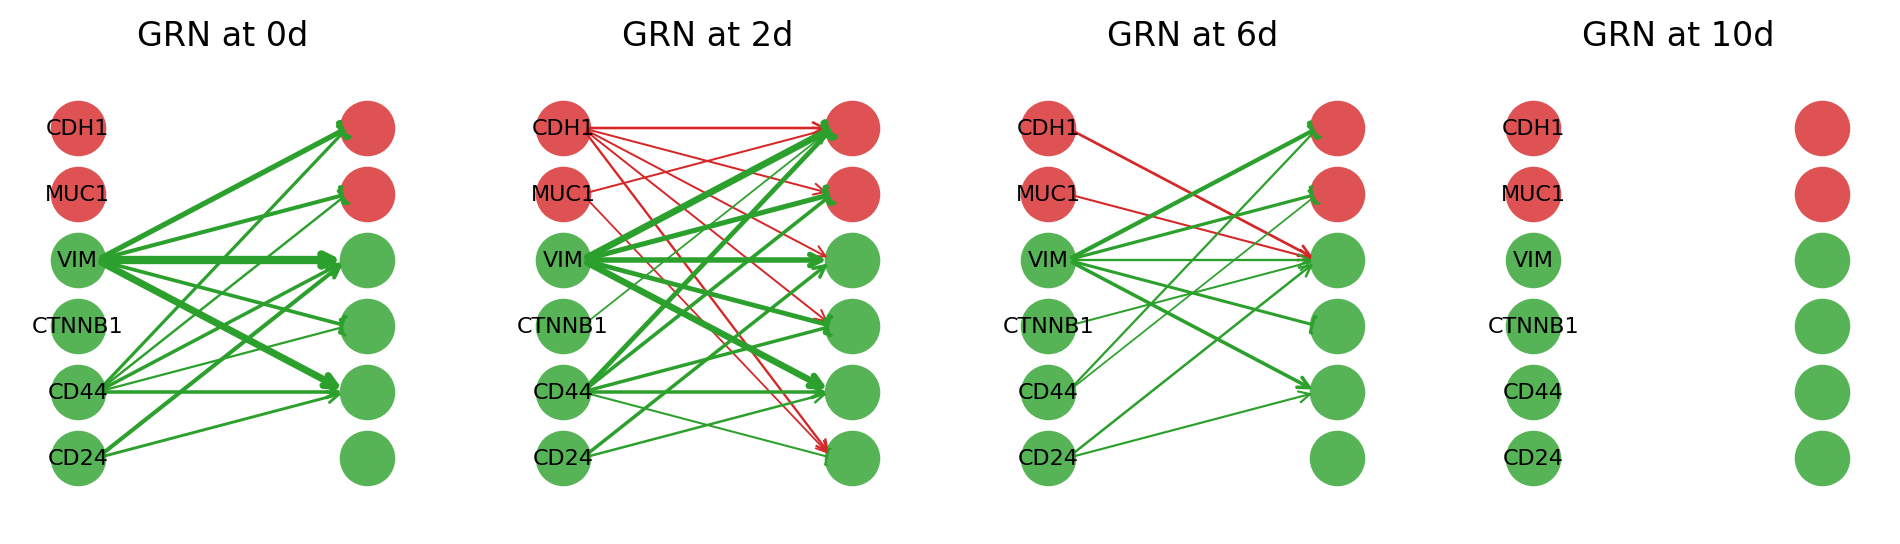

In [5]:
plot_grn(JAC,train_time,gene_index,gene_name,'EMT_GRN',filepath,threshold= 0.2) 

## Cell fate landscape

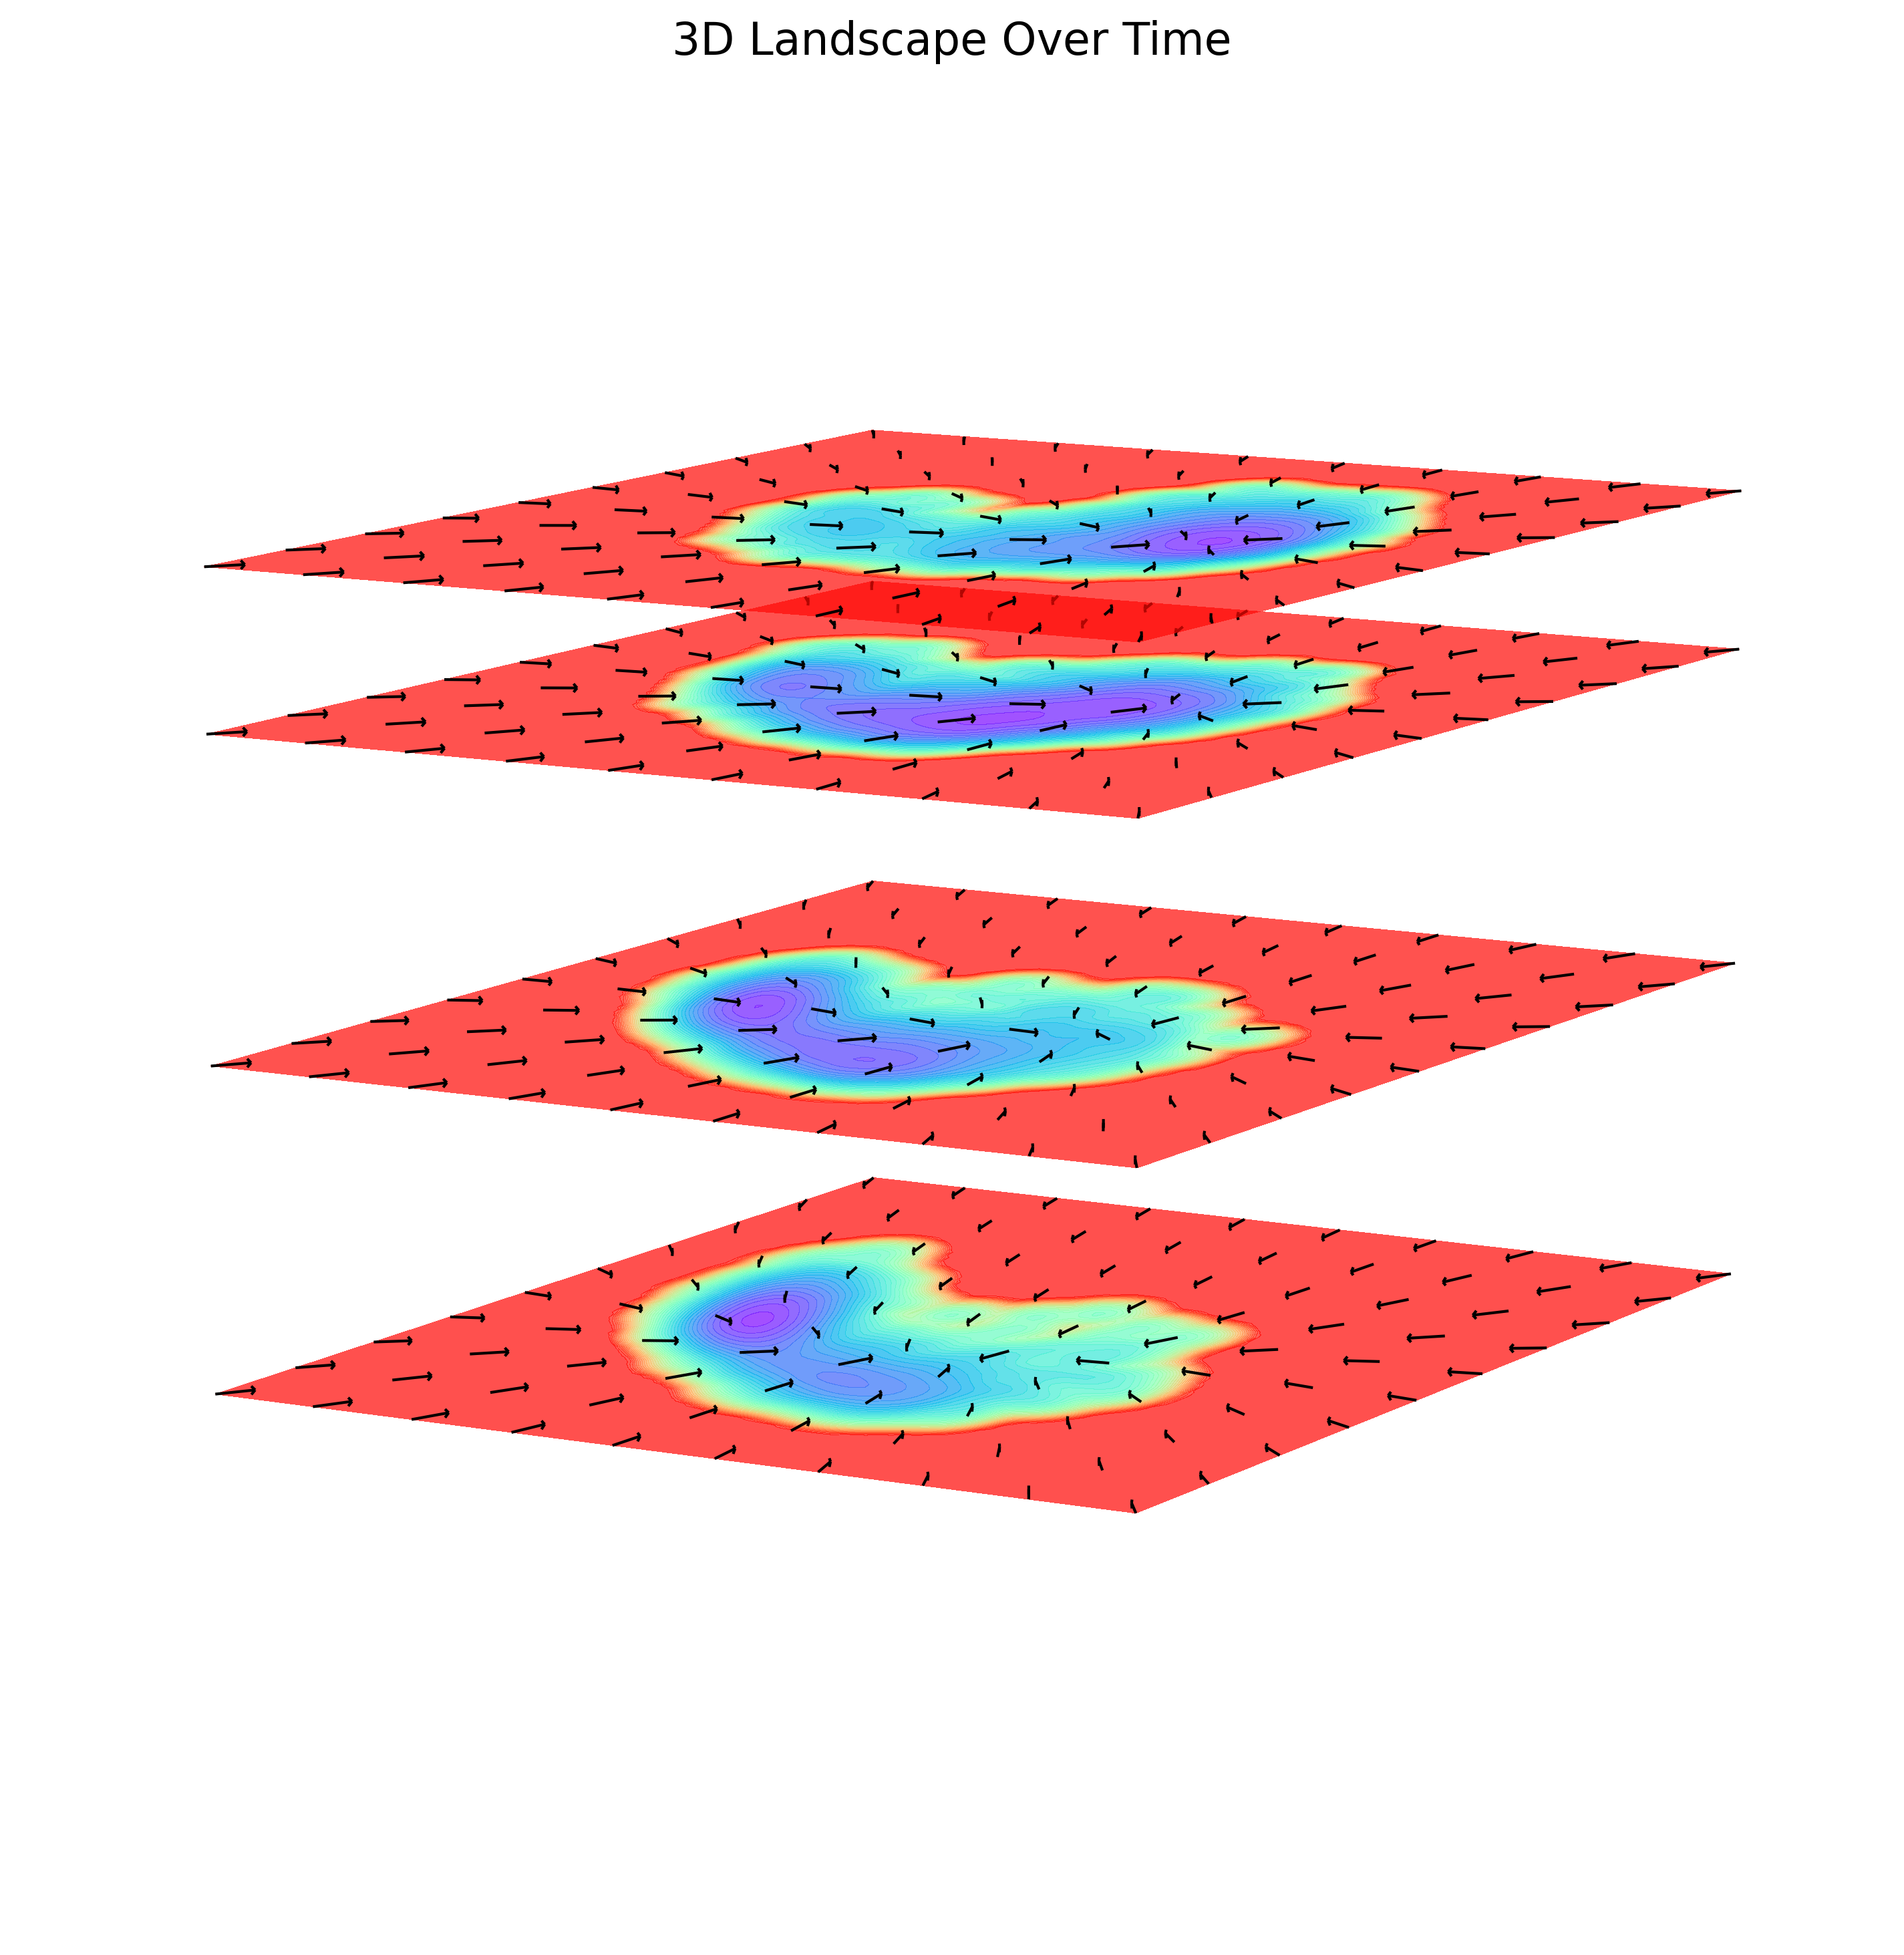

In [6]:
plot_3d_landscape(func,data_train,train_time,integral_time,args,device)

## Stochastic Trajectory Analysis (STA)

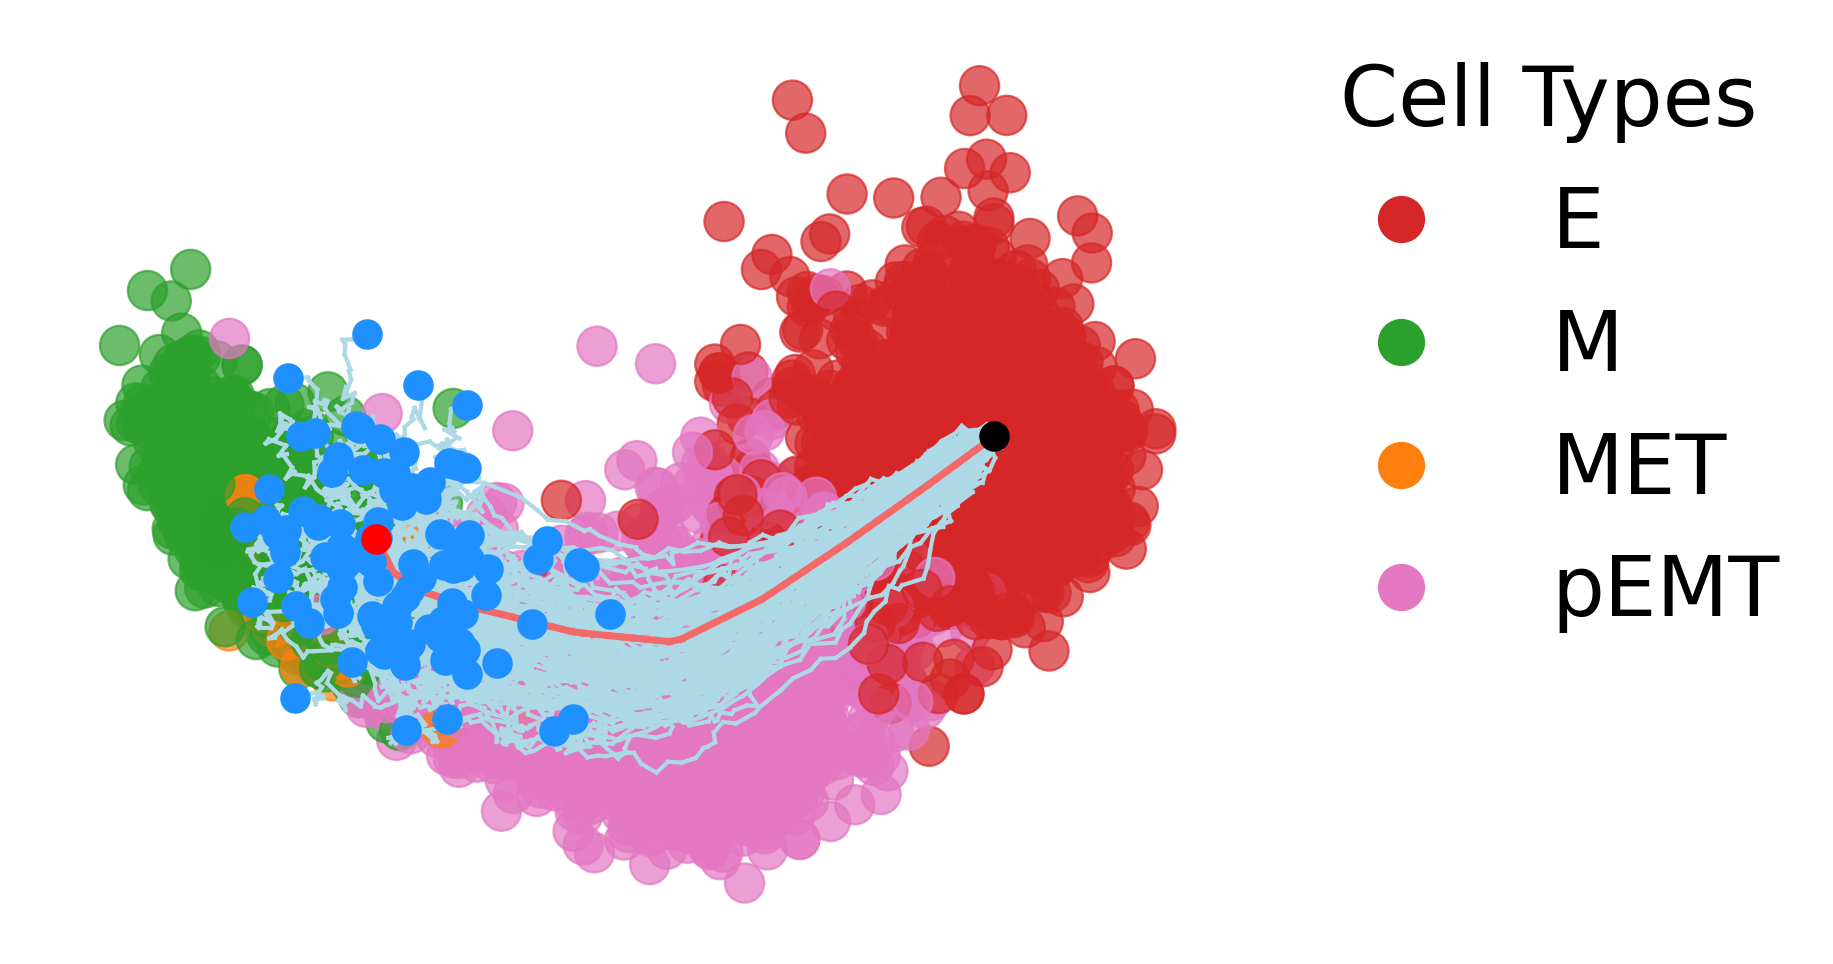

In [7]:
plot_2d_sde_fore(func,data_train,integral_time,args,device,start_point=[[1.3038, 0.3213]],start_time=0,end_time=1,
                 data_type=data_type,num=100,ode_setp = 0.01,n=2)

## Train random forest classifier

              precision    recall  f1-score   support

           E       0.93      0.93      0.93      2886
           M       0.94      0.88      0.91      3187
         MET       0.89      0.97      0.93      3314
        pEMT       0.91      0.88      0.90      3467

    accuracy                           0.92     12854
   macro avg       0.92      0.92      0.92     12854
weighted avg       0.92      0.92      0.92     12854



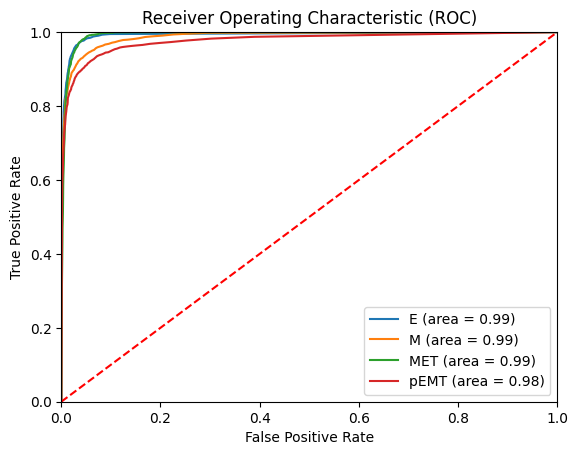

In [8]:
##################### Random Forest Classifier
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve, confusion_matrix
# Concatenate data into a single array
X = torch.cat(data_train).cpu().numpy()  # Feature data
y = np.concatenate(data_type)  # Label data
#############################################################################################################
# Extract samples of type MET
met_indices = np.where(y == 'MET')[0]  # Get the indices of MET type samples
met_samples = X[met_indices]  # Extract MET type samples

# met_train = Sampling(15000, [0], 0, [met_samples], 0.001, device)
# Randomly select existing samples for replication
noise = np.random.normal(0, 0.001, [15000, 2])  # Generate noise
additional_samples_indices = np.random.choice(met_indices, size=15000, replace=True)
additional_samples = X[additional_samples_indices] + noise  # Replicated samples
augmented_labels = np.array(['MET'] * additional_samples.shape[0])  # Create MET label array
y = np.concatenate((y, augmented_labels))  # Integrate MET labels into y
X = np.concatenate([X, additional_samples])
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
classifier.fit(X_train, y_train)
# Evaluate the model
y_pred = classifier.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot ROC curve
# Calculate ROC curve for each class
for i, label in enumerate(np.unique(y)):
    y_score = classifier.predict_proba(X_test)[:, i]  # Get prediction probabilities for each class
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label=label)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label='{} (area = {:.2f})'.format(label, roc_auc))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig(filepath + 'ROC.png', dpi=300, bbox_inches='tight')
plt.show()

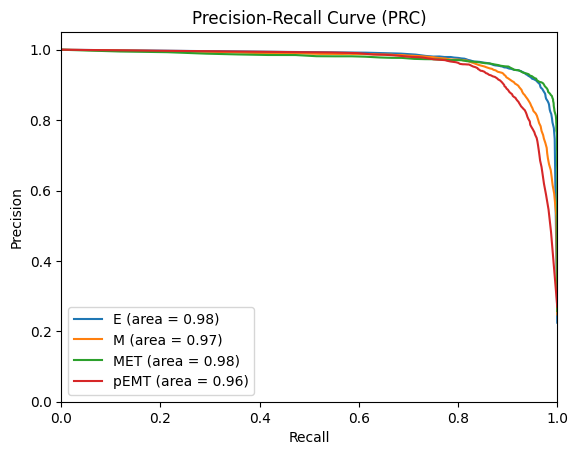

In [9]:
# Plot PRC curve
# Calculate PRC curve for each class
for i, label in enumerate(np.unique(y)):
    y_score = classifier.predict_proba(X_test)[:, i]  # Get prediction probabilities for each class
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=label)
    pr_auc = auc(recall, precision)
    
    plt.plot(recall, precision, label='{} (area = {:.2f})'.format(label, pr_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (PRC)')
plt.legend()  # loc='lower left'
plt.savefig(filepath + 'PRC.png', dpi=300, bbox_inches='tight')
plt.show()

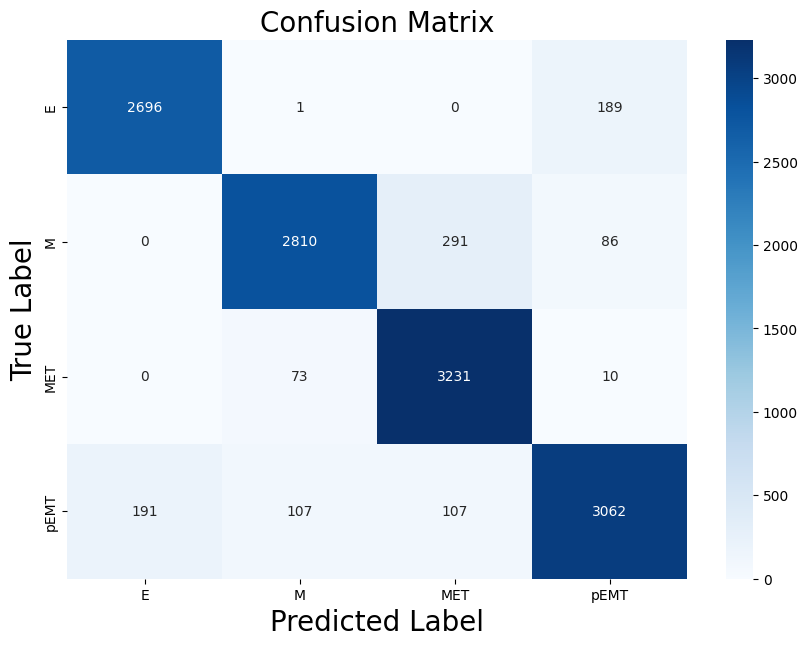

['C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Output\\random_forest_classifier_EMT.pkl']

In [10]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.savefig(filepath + 'Confusion Matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Save the model
joblib.dump(classifier, filepath + 'random_forest_classifier_EMT.pkl')

## Identifying trajectory-related critical genes 

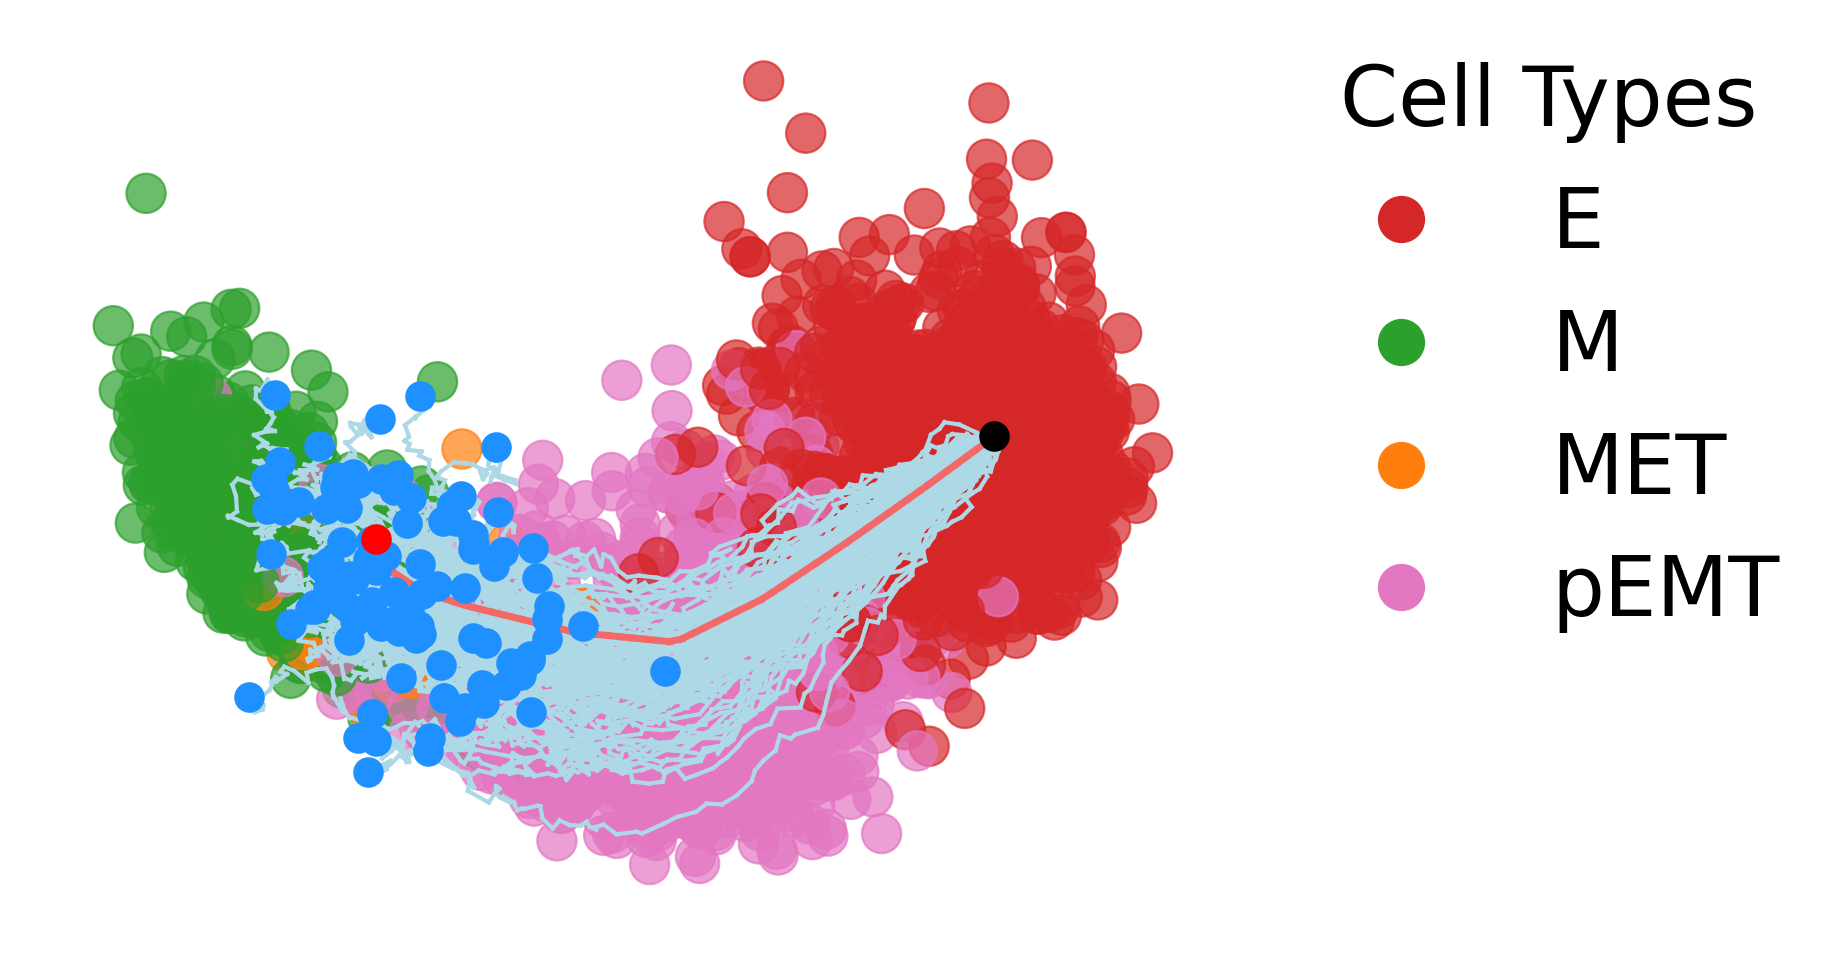

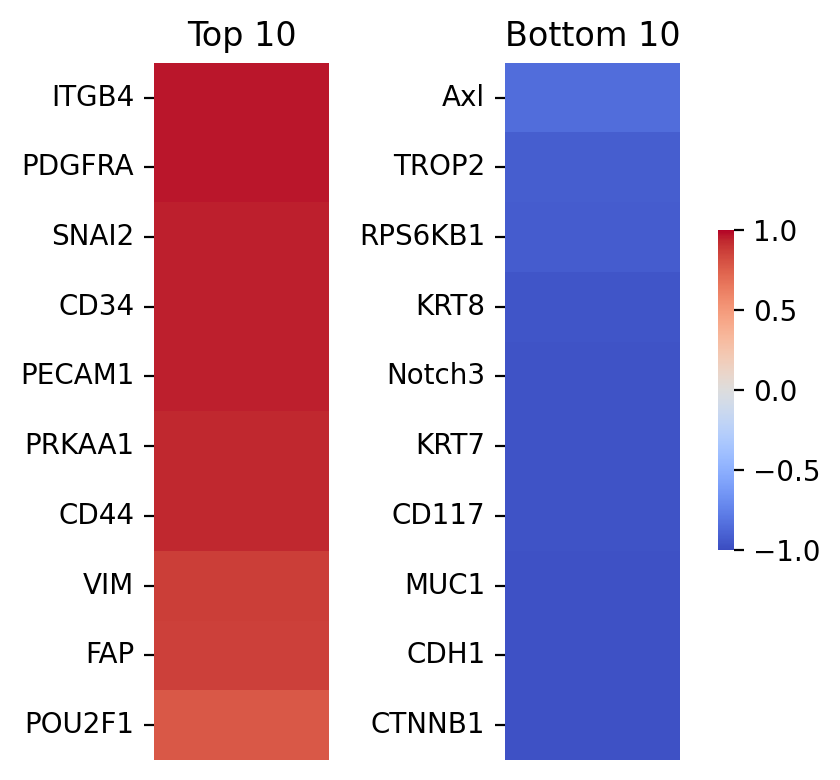

In [4]:
classifier = joblib.load(filepath+'random_forest_classifier_EMT.pkl')
pca_model = joblib.load(filepath+'pca_model_2d.pkl')
plot_2d_sde_fore(func,data_train,integral_time,args,device,start_point=[[1.3038, 0.3213]],start_time=0,end_time=1,
                 data_type=data_type,num=100,ode_setp = 0.01,n=2,classifier = classifier)

import pandas as pd
gene_name = pd.read_csv('C:\\Users\\JTliu\\Desktop\\DiffusionOT-main\\Rawdata\\gene_name_EMT.csv', header=0,index_col=0).values.tolist()
gene_name = [name[0] for name in gene_name]  

plot_de_fore(func,data_train,integral_time,args,device,start_point=[[1.3038, 0.3213]],
                 start_time=0,end_time=1,ode_setp = 0.01,pca_model=pca_model,
                 gene_name=gene_name,filepath=filepath)

## Gene perturbation analysis

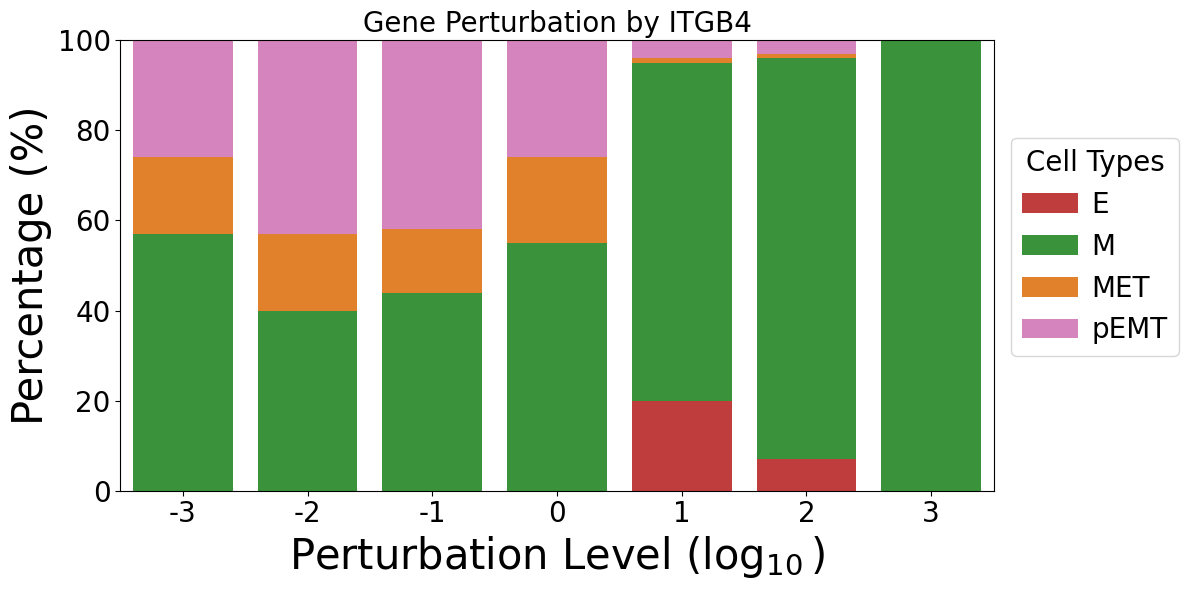

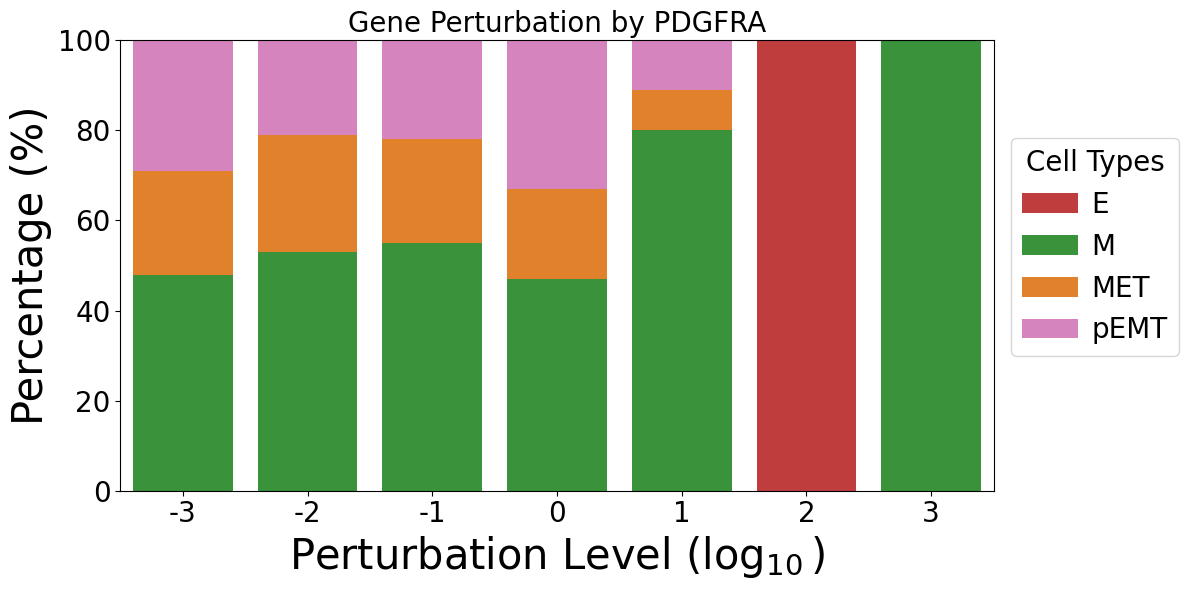

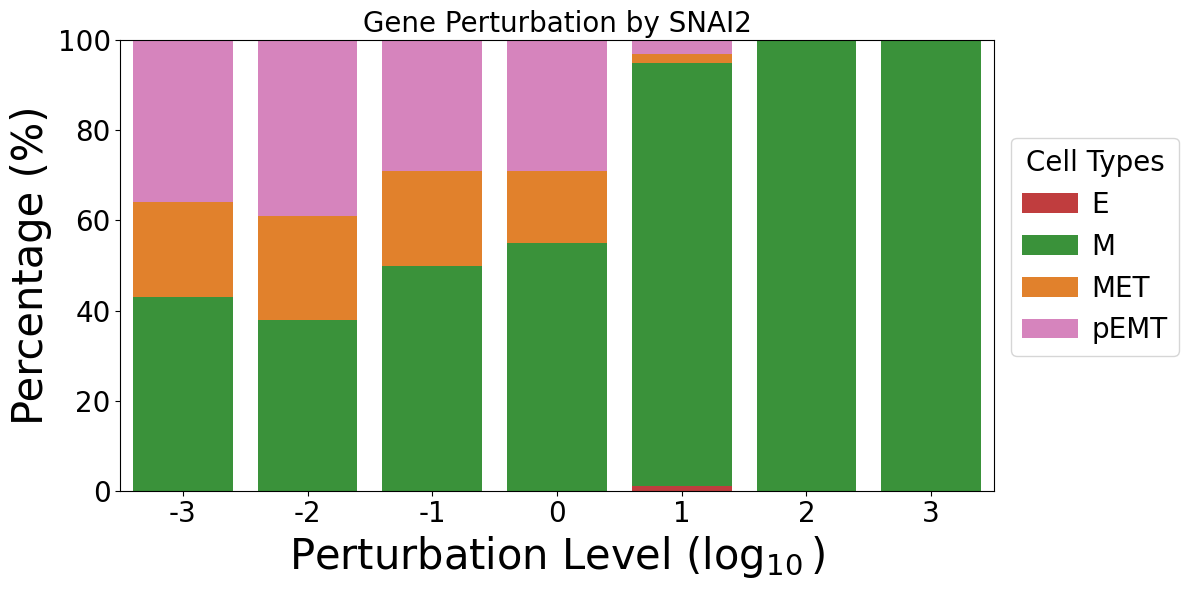

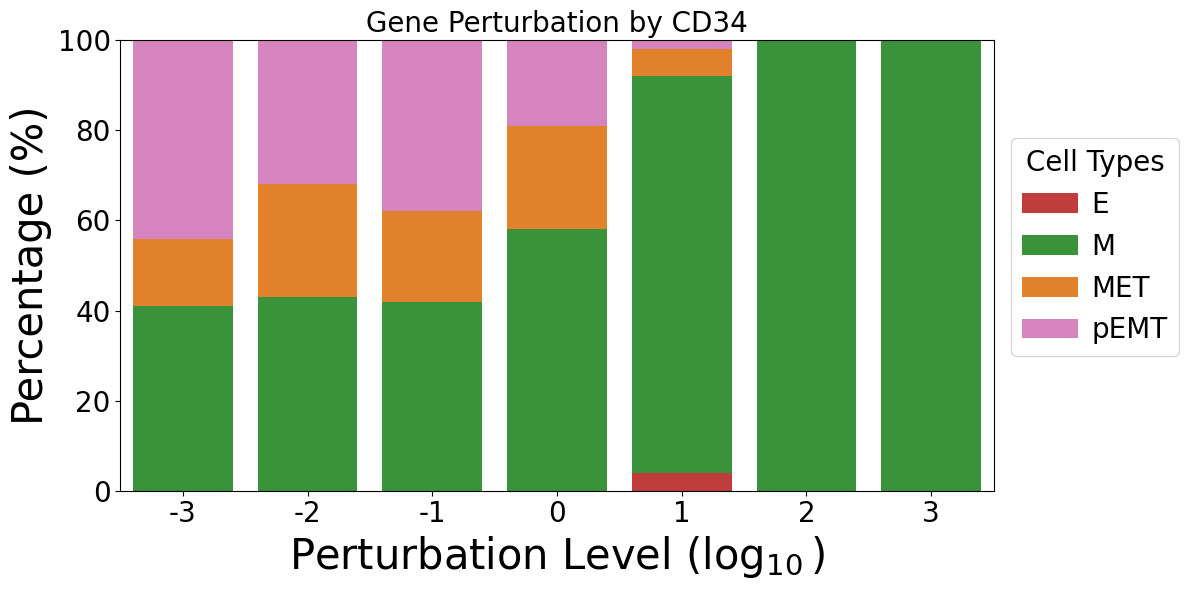

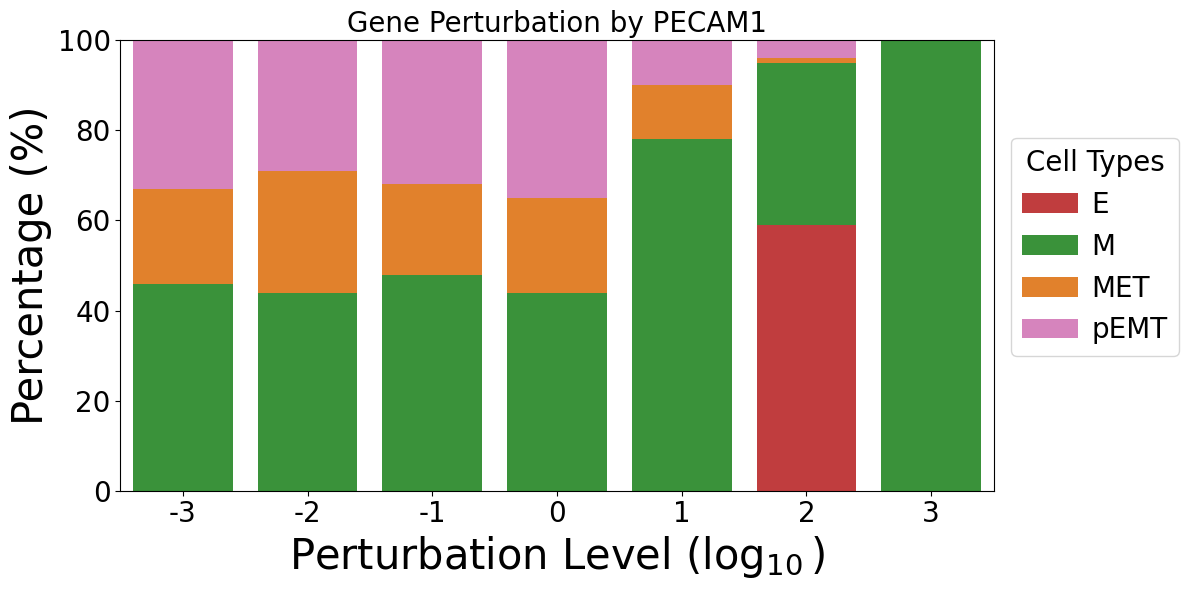

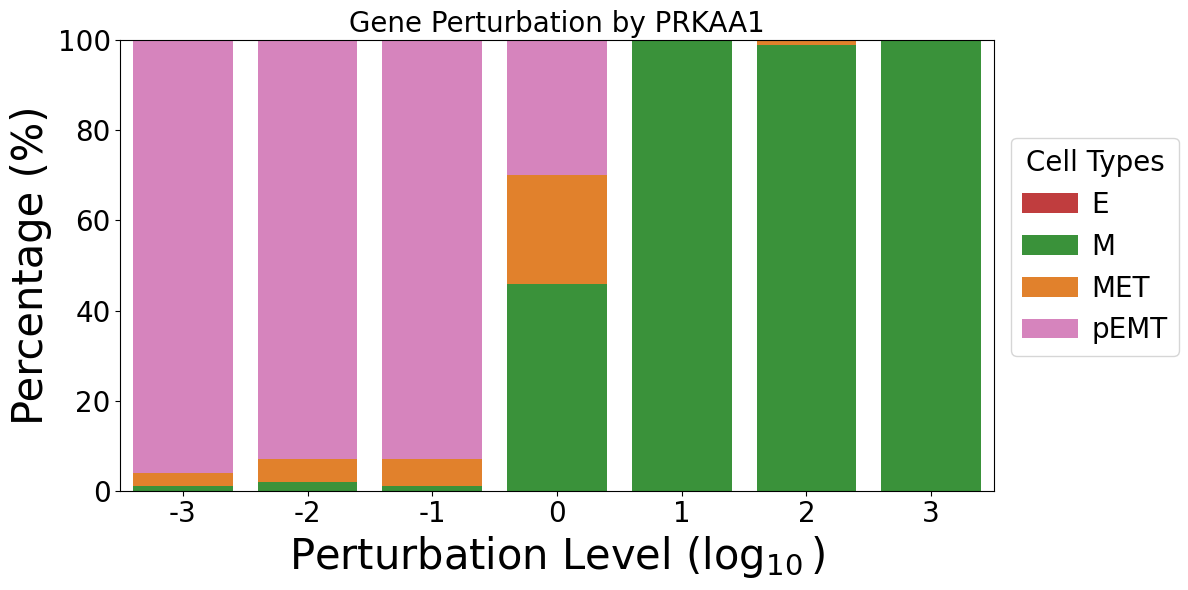

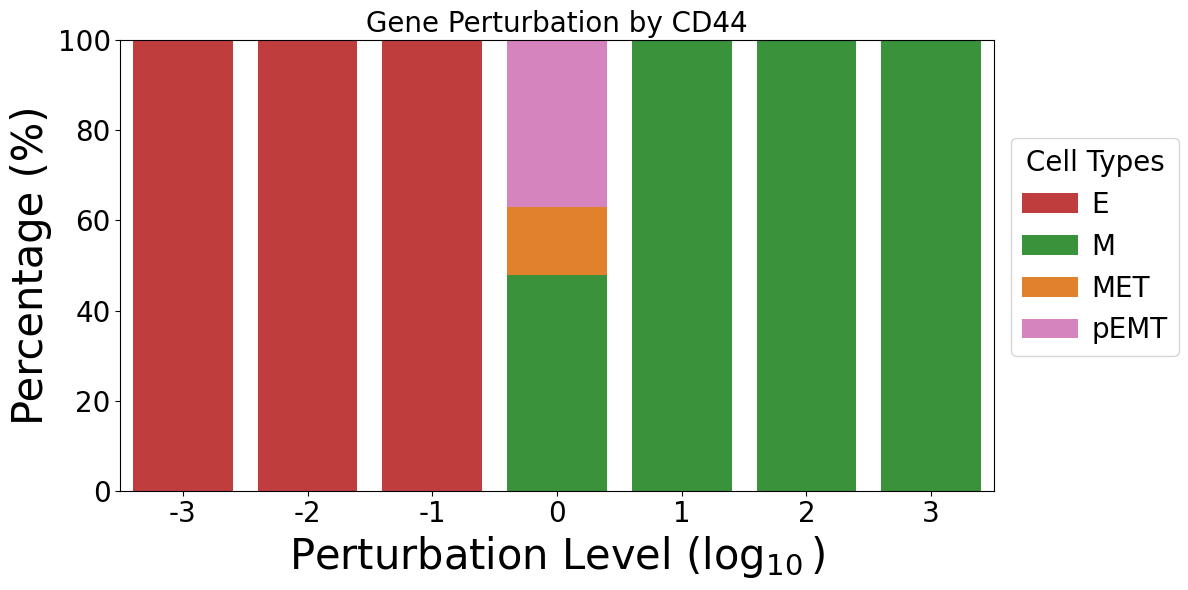

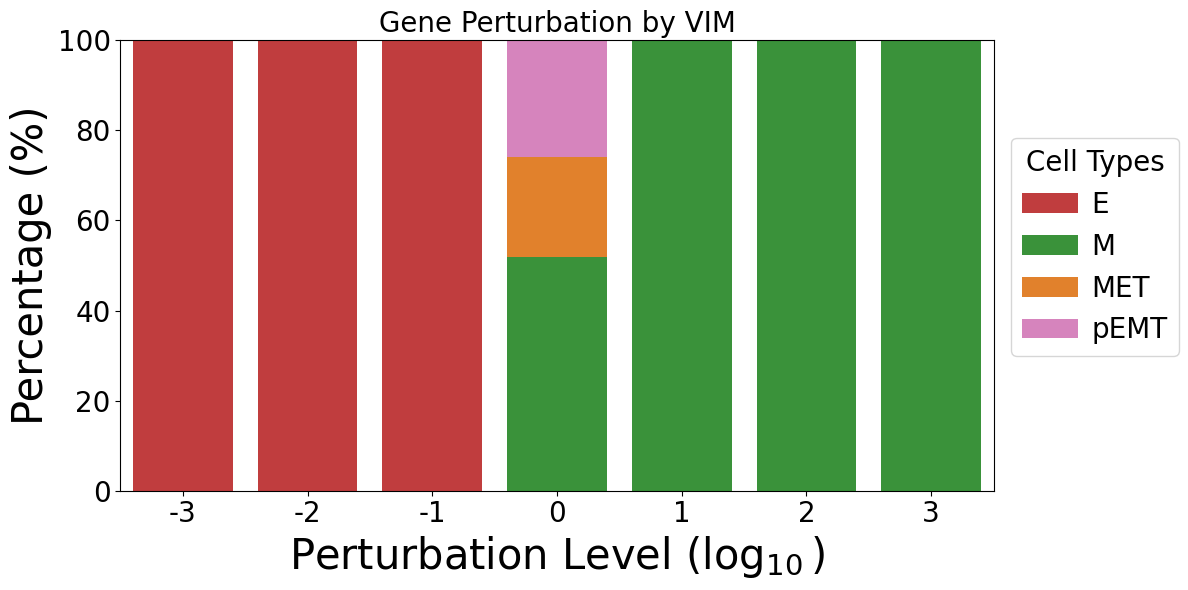

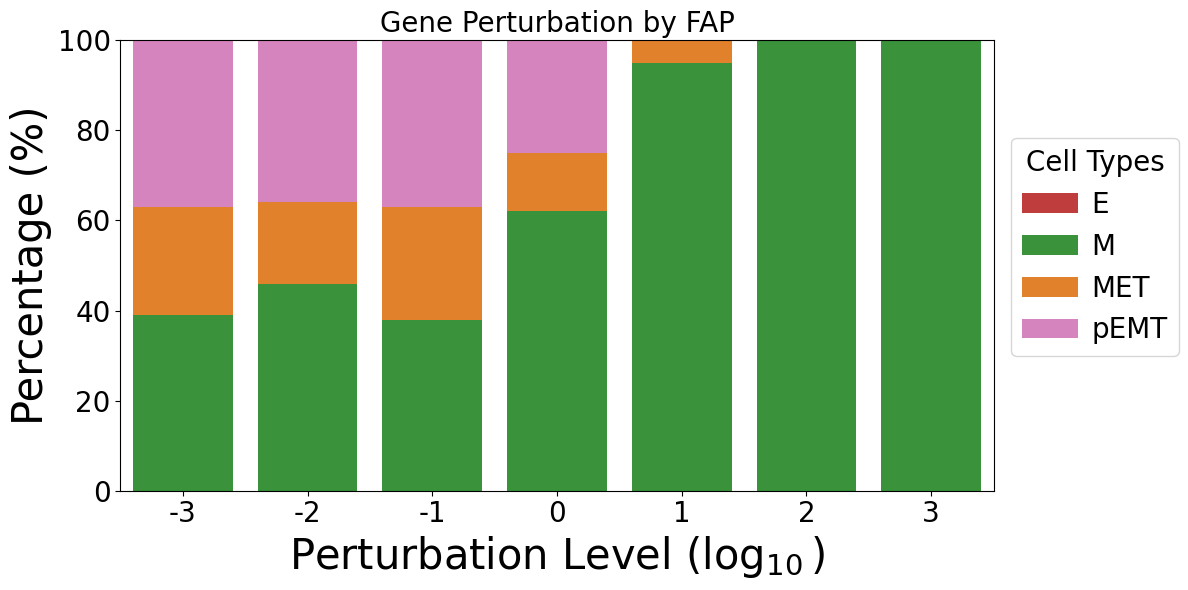

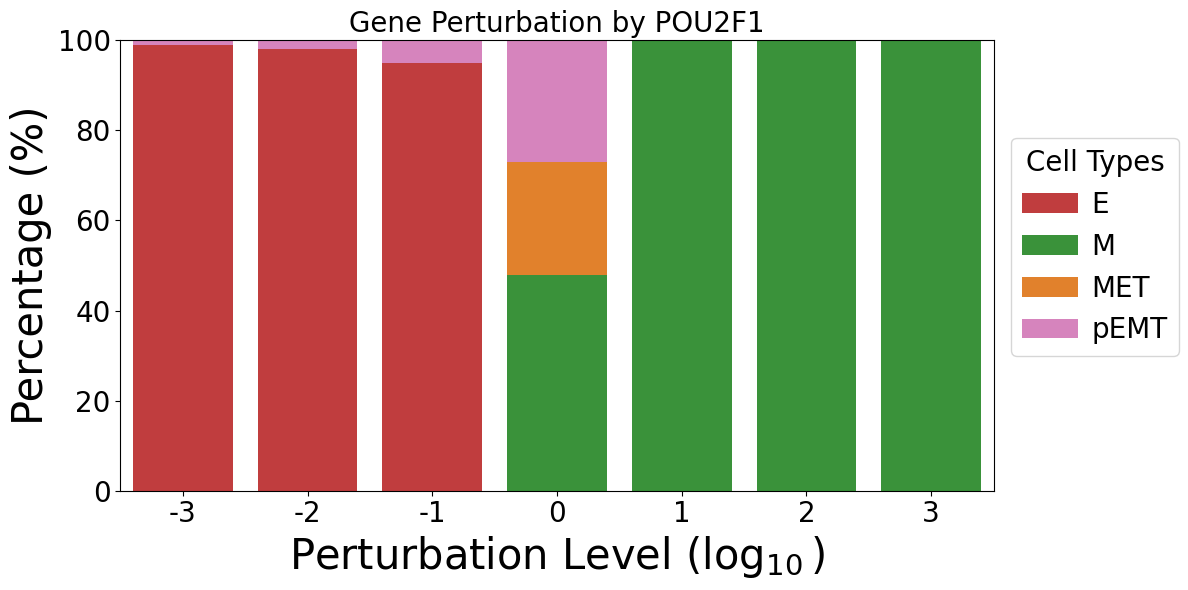

In [5]:
gene_list = ['ITGB4','PDGFRA','SNAI2','CD34','PECAM1',
             'PRKAA1','CD44','VIM','FAP', 'POU2F1']
gene_index = [gene_name.index(elem) for elem in [elem for elem in gene_list if elem in gene_name]]
for i in range(len(gene_list)):
    plot_gene_fore(func,data_train,integral_time,args,device,start_point=[[1.3038, 0.3213]],
                 start_time=0,end_time=1,ode_setp = 0.01,pca_model=pca_model,classifier=classifier,
                 gene_name=gene_list[i],gene_index=gene_index[i],filepath=filepath,num=100)

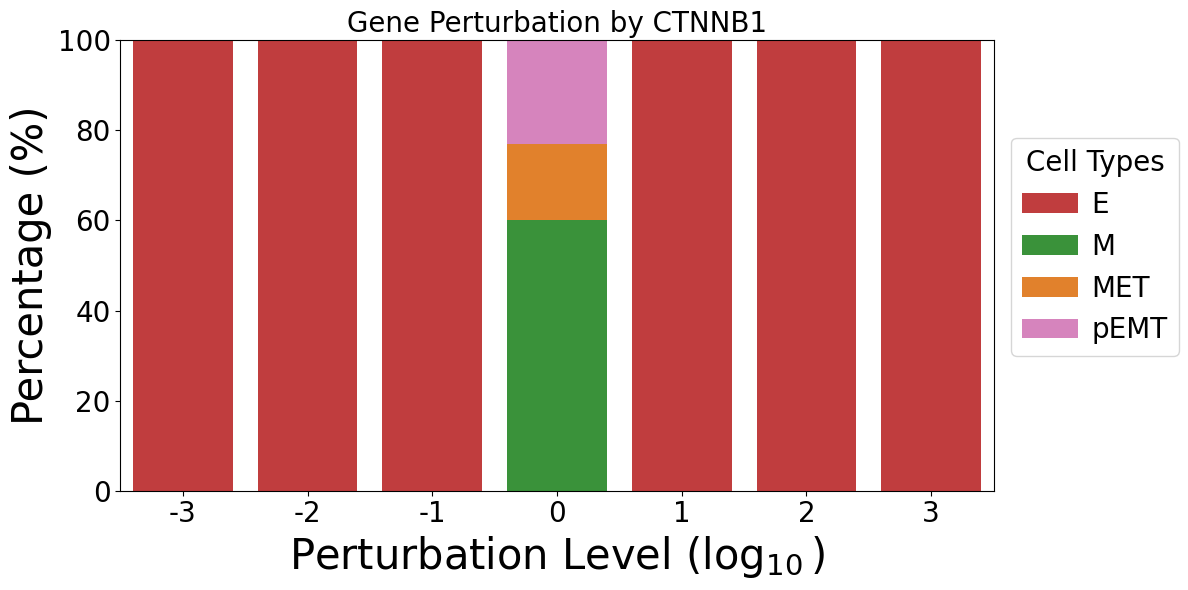

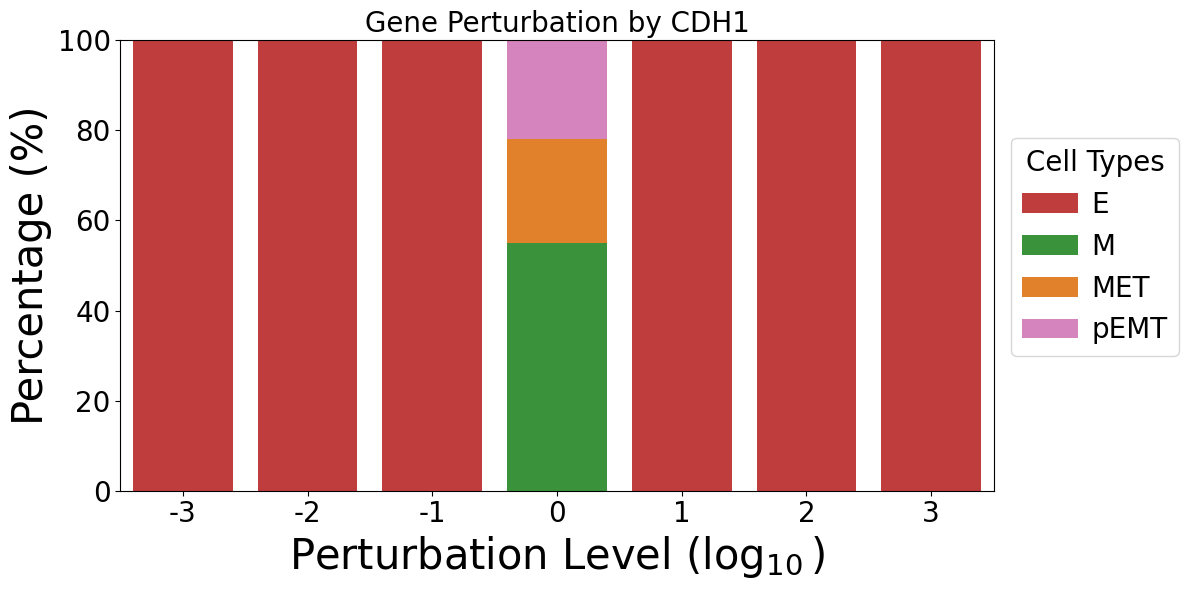

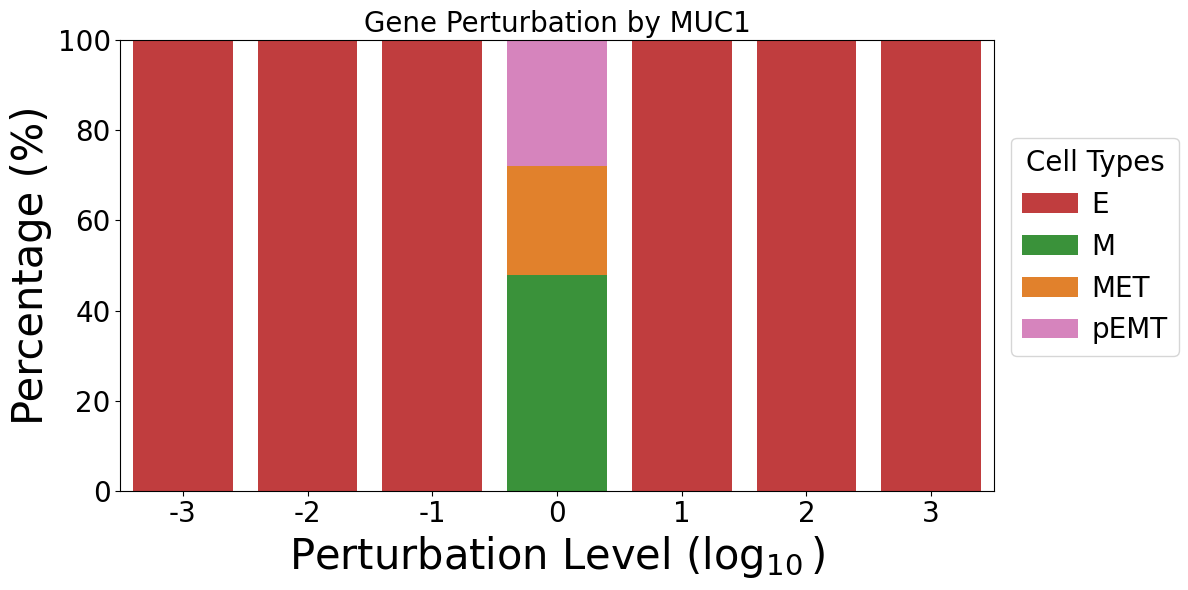

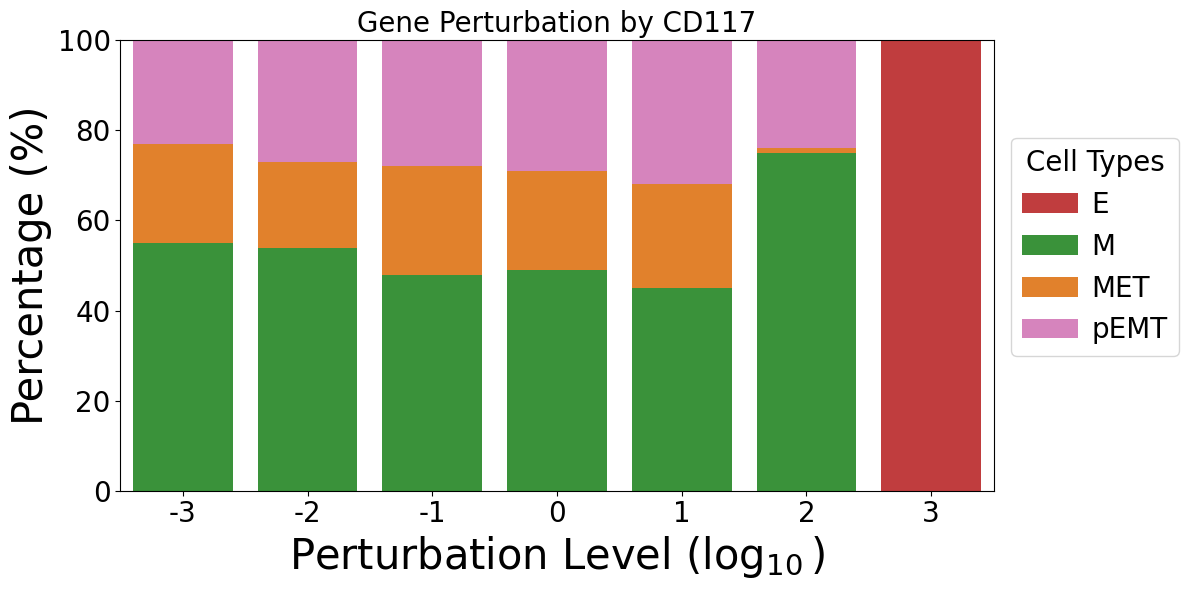

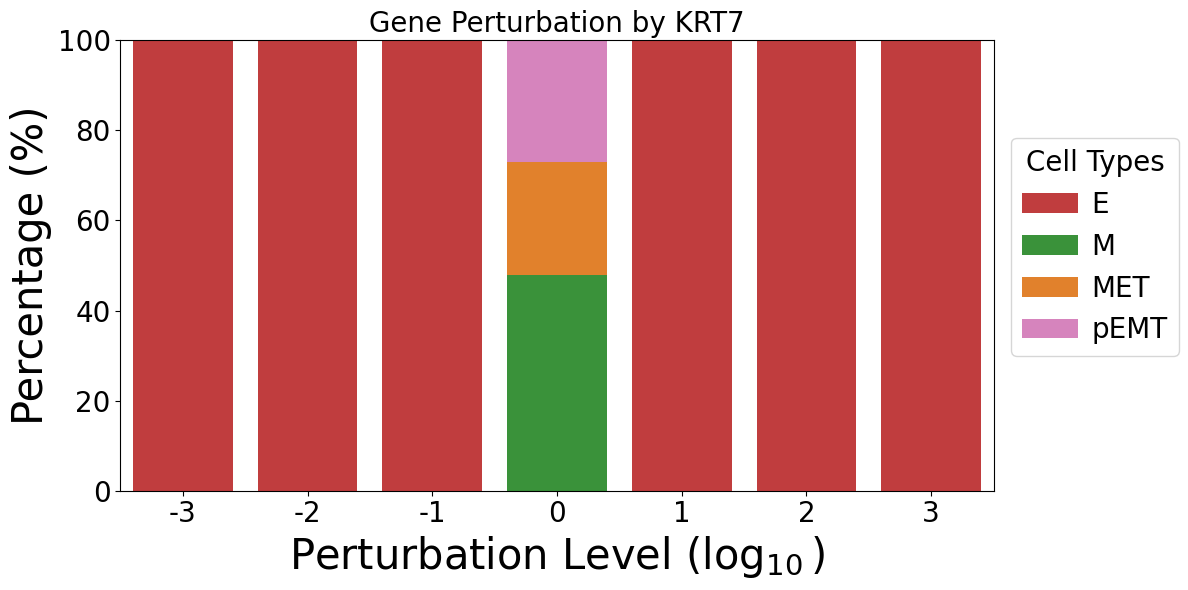

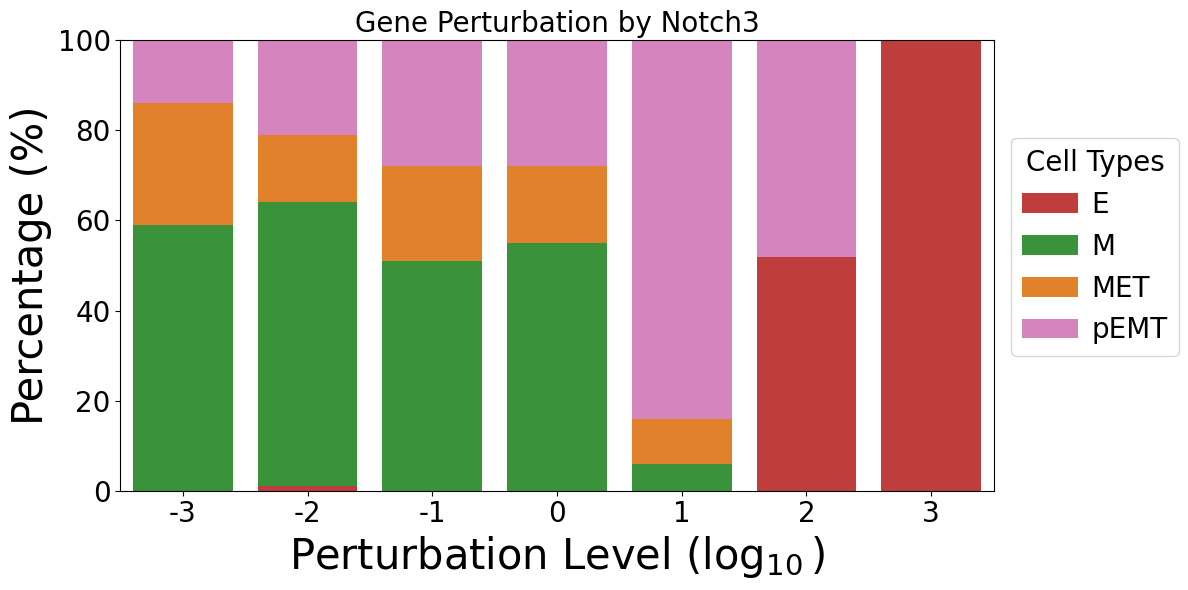

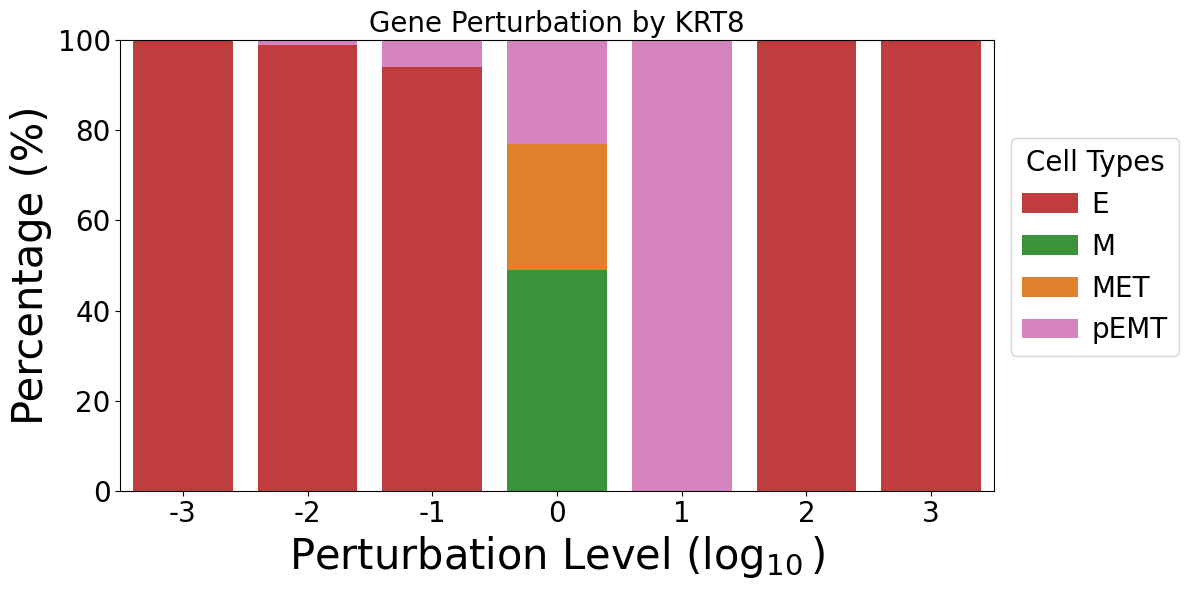

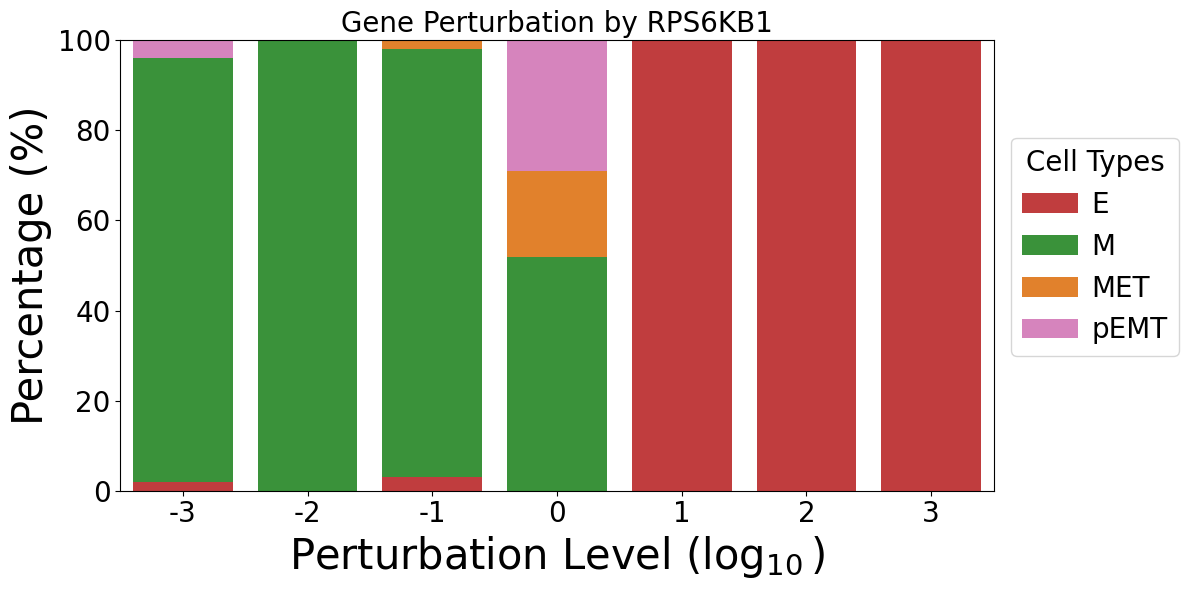

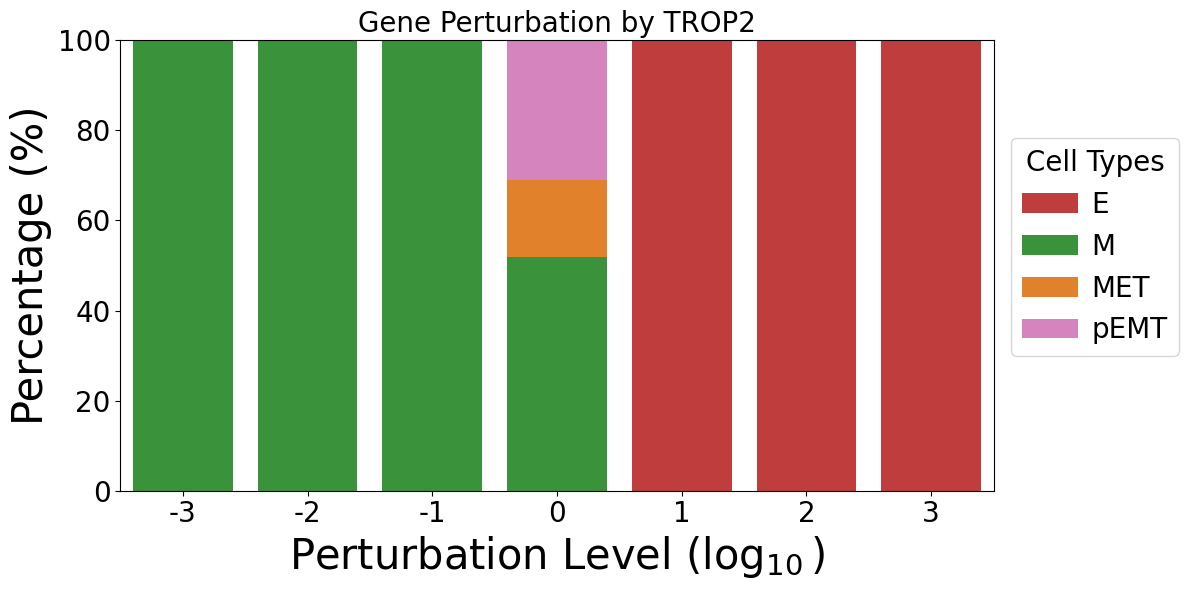

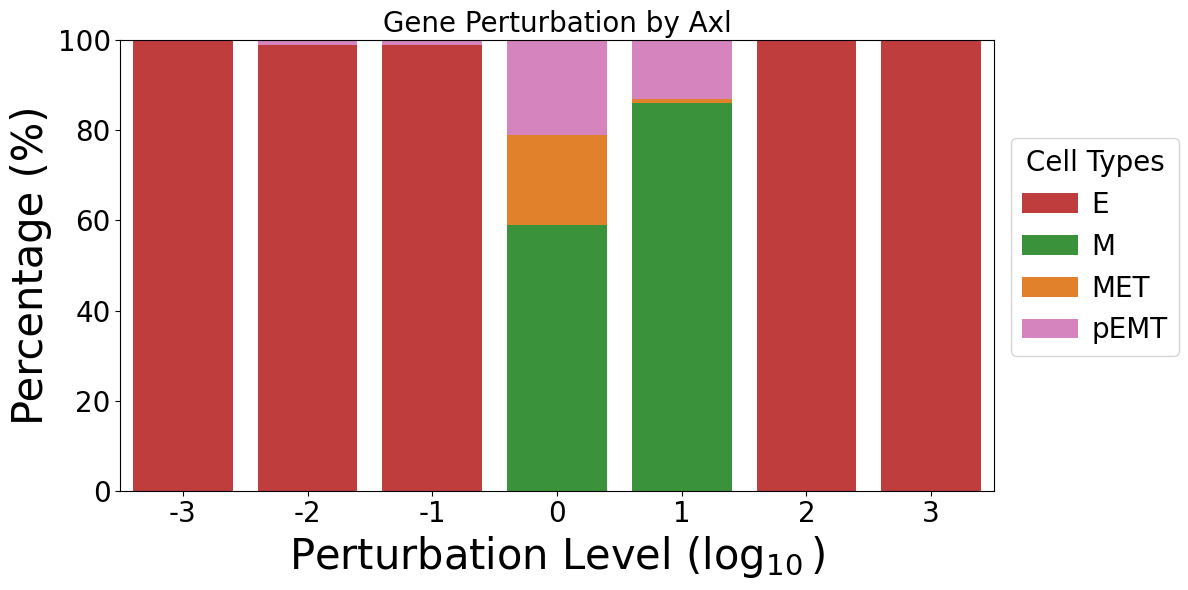

In [6]:
gene_list = ['CTNNB1','CDH1','MUC1','CD117','KRT7',
             'Notch3','KRT8','RPS6KB1','TROP2', 'Axl']
gene_index = [gene_name.index(elem) for elem in [elem for elem in gene_list if elem in gene_name]]
for i in range(len(gene_list)):
    plot_gene_fore(func,data_train,integral_time,args,device,start_point=[[1.3038, 0.3213]],
                 start_time=0,end_time=1,ode_setp = 0.01,pca_model=pca_model,classifier=classifier,
                 gene_name=gene_list[i],gene_index=gene_index[i],filepath=filepath,num=100)